# CS-502 Homework 2: Graph Neural Networks

Author: Mika Senghaas (mika.senghaas@epfl.ch)

This homework assignment implements a custom **graph neural network** (GNN) in pure [Pytorch](https://pytorch.org) and perform experiments on the [MUTAG]() dataset for graph classficiation of chemcical compounds. MUTAG consists of a collection of chemcical compounds, each represented as a graph. Here, *nodes* are atoms and identified by the atom type, *edges* are chemical bounds between the atoms with features indicating the chemical bond type. Each graph represents a chemical compound and is labelled as either *mutagenic* (positive) or *non-mutagenic* (negative) class. 

## Imports & Setup

We import the necessary modules and set global parameters. Note, that this notebook was run in the lastest minor release of Python `3.9`.

In [1]:
# Standard library
import os
import sys
import time
import uuid
import json
import shutil
import random
from itertools import product
from collections import Counter

# External libraries
import pandas as pd
import networkx as nx
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split

In [2]:
print(sys.version)

3.9.16 (main, Dec 16 2022, 22:25:05) 
[Clang 14.0.0 (clang-1400.0.29.202)]


In [3]:
# Global variables
BASE_PATH = os.getcwd()
DATA_PATH = os.path.join(BASE_PATH, 'data', 'mutag.jsonl')
PLOT_PATH = os.path.join(BASE_PATH, 'plots')

# Check if data exists and is in the right place
assert os.path.exists(DATA_PATH), f'❌ Error: Please download the data and place it in {DATA_PATH}'

# Create plot path if it doesn't exist
shutil.rmtree(PLOT_PATH)
os.makedirs(PLOT_PATH, exist_ok=True)

In [4]:
# Set seed for reproducibility
random.seed(1)
torch.manual_seed(1)

# Set plot styles
sns.set_style("whitegrid")

# Set float precision for pandas
pd.set_option("display.precision", 2)

# Test data
test_x = torch.eye(3)
test_adj = torch.randint(0, 2, (3, 3)).float()
test_e = torch.randint(0, 2, (3, 3, 4)).float()

In [5]:
class Meta(type):
    def __repr__(cls):
        return cls.__name__

## Part 1: Implementing Different Graph Convolution and Pooling Layers

---

### Normal Convolution (Graph Convolution)

A regular graph convolution in the $l$-th layer computes the embedding of the $v$-th node, $\mathbf{h}_v$ through

$$
\mathbf{h}_v^{(l+1)} = \sigma\left( \mathbf{W}_l \sum_{u\in N(v)} \frac{\mathbf{h}_u^{(l)}}{|N(v)|} + \mathbf{B}_l \mathbf{h}_v^{(l)} \right).
$$

Note, that here $\sigma$ is a non-linearity, $\mathbf{W}_l$ and $\mathbf{B}_l$ are both trainable weight matrices with dimension 
$\text{in\_features} \times \text{out\_features}$ and $N(v)$ is the set of adjacent nodes in the graph.

We can represent the average over the neighbourhood of node $v$ through a matrix product of the adjacency matrix $\mathbf{A}$ with the matrix $\mathbf{H}^{(l)}=\left[\mathbf{h}^{(l)}_1, ..., \mathbf{h}^{(l)}_{|V|}\right]$ holding all node embeddings in the $l$ layer (corrected by the inverse of the degree $\tilde{A}$ to obtain an average) as

$$
H^{(l+1)} = \sigma\left( \tilde{A}H^{(l)}W_l^\top + H^{(l)}B_l^\top \right).
$$

In [6]:
class GraphConv(nn.Module, metaclass=Meta):
    """Basic graph convolutional layer implementing the simple neighborhood aggregation."""

    def __init__(self, in_features, out_features, activation=None):
        """
        Initialize the graph convolutional layer.
        
        Args:
            in_features (int): number of input node features.
            out_features (int): number of output node features.
            activation (nn.Module or callable): activation function to apply. (optional)
        """
        super().__init__()
        
        # Save parameters
        self.in_features = in_features
        self.out_features = out_features

        # Linear transformation layers
        self.weight = nn.Linear(in_features, out_features, bias=False)
        self.bias = nn.Linear(in_features, out_features, bias=False)

        # Non-linear activation function (optional)
        self.activation = activation

    def forward(self, x, adj):
        """
        Perform graph convolution operation.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).
            adj (Tensor): Adjacency matrix of the graph, shape (num_nodes, num_nodes).

        Returns:
            Tensor: Output node features after graph convolution, shape (num_nodes, out_features).
        """
        # Neighbourhood aggregation
        adj = adj / adj.sum(1, keepdim=True).clamp(1)
        x_agg = adj @ x

        # Graph convolution
        x = self.weight(x_agg) + self.bias(x)

        # Apply non-linear activation if specified
        if self.activation:
            return self.activation(x)
        return x

In [7]:
# Test graph convolution
conv = GraphConv(3, 2)
out = conv(test_x, test_adj)

assert out.shape == (3, 2), f"Output shape shold be 3x2 but is {out.shape}"
assert repr(GraphConv) == "GraphConv", f"Class name should be `GraphConv`, but is {repr(GraphConv)}"

print("Tests passed. ✅")

Tests passed. ✅


### GraphSAGE (Customised Aggregation)

GraphSAGE is a generalised version of the regular graph convolution, in which any type of aggregation can be applied to. Instead of adding the result of two matrix products and performing a non-linearity, here the original node embeddings are concatenated with the aggregated neighbourhood embeddings and then linearly transformed. The equation for the GraphSAGE layer is:

$$
\mathbf{h}_v^{(l+1)} = \sigma\left( \mathbf{W}_l \cdot \mathrm{CONCAT} \left[\mathbf{h}_v^{(l)}, \mathrm{AGG} \left(\left\{\mathbf{h}_u^{(l)}, \forall u\in N(v) \right\}\right) \right] \right),
$$

where $v$ index the node, $l$ the layer, $\mathbf{h}$ are the node embeddings, $\sigma$ is a non-linearity, $N(v)$ is the set of neighbor of node $v$, and $\mathbf{W}$ is the trainable weight matrix of the layer. $\mathrm{CONCAT}$ is the concatenation operation, while $\mathrm{AGG}$ is an arbitrary aggregation function.

In [8]:
# Aggregations
class MeanAggregation(nn.Module):
    """Aggregate node features by averaging over the neighborhood."""
    def __init__(self):
        super().__init__()

    def forward(self, x, adj):
        adj = adj / adj.sum(1, keepdim=True).clamp(1)

        return adj @ x
    
class SumAggregation(nn.Module):
    """Aggregate node features by summing over the neighborhood."""
    def __init__(self):
        super().__init__()

    def forward(self, x, adj):
        return adj @ x

In [9]:
class GraphSAGEConv(nn.Module, metaclass=Meta):
    """GraphSAGE convolutional layer."""
    
    def __init__(self, 
        in_features, 
        out_features, 
        aggregation=SumAggregation,
        activation=None):
        """
        Initialize the GraphSAGE convolutional layer.
        
        Args:
            in_features (int): number of input node features.
            out_features (int): number of output node features.
            aggregation (nn.Module or callable): aggregation function to apply, as x_agg = aggegration(x, adj).
            activation (nn.Module or callable): activation function to apply. (optional)
        """
        super().__init__()

        # Save parameters
        self.in_features = in_features
        self.out_features = out_features

        # Linear transformation layer (no bias)
        torch.manual_seed(0)
        self.weight = nn.Linear(2*in_features, out_features, bias=False)

        # Aggregation function
        self.aggregation = aggregation()

        # Non-linear activation function (optional)
        self.activation = activation

    def forward(self, x, adj):
        """
        Perform graph convolution operation.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).
            adj (Tensor): Adjacency matrix of the graph, typically sparse, shape (num_nodes, num_nodes).

        Returns:
            Tensor: Output node features after graph convolution, shape (num_nodes, out_features).
        """
        # Neighbourhood aggregation
        x_agg = self.aggregation(x, adj)

        # Concatenate node features and aggregated features
        x_cat = torch.cat([x, x_agg], dim=1)
        
        # Apply linear transformation
        x = self.weight(x_cat)

        # Apply non-linear activation if specified
        if self.activation:
            return self.activation(x)
        return x

In [10]:
# Test GraphSAGE
conv = GraphSAGEConv(3, 2, aggregation=MeanAggregation)
out = conv(test_x, test_adj)

assert out.shape == (3, 2), f"Output shape shold be 3x2 but is {out.shape}"
assert repr(GraphSAGEConv) == "GraphSAGEConv", f"Class name should be `GraphSAGEConv`, but is {repr(GraphSAGEConv)}"

print("Tests passed. ✅")

Tests passed. ✅


### Attention-based Convolution

The attention-based convolution is a generalisation of the regular graph convolution, in which the aggregation of the neighbourhood is weighted by an attention mechanism. The equation for the attention-based convolution is:

$$
\mathbf{h}_v^{(l+1)} = \sigma\left(
    \sum_{u \in N(v) \cup \{v\}} \alpha_{vu}^{(l)} \mathbf{W}_l \mathbf{\tilde{h}}_u^{(l)}
    \right)
$$

where $N(v)$ is the neighborhood of node $v$, $\alpha_{vu}^{(l)}$ is the attention weight between node $v$ and $u$ in layer $l$ and is computed as:

$$
\alpha_{vu}^{(l)} = \mathrm{softmax}_{N(v)}\left(
    \textrm{LeakyReLU}\left(
        \mathbf{S}^T\cdot \textrm{CONCAT}(\mathbf{\tilde{h}}_v^{(l)}, \mathbf{\tilde{h}}_u^{(l)}
        \right)
    \right)
$$

and $\mathbf{\tilde{h}}_v^{(l)'}$ is the linearly transformed node embedding of node $v$ in layer $l$:

$$
\mathbf{\tilde{h}}_v^{(l)} = \mathbf{W}_l \mathbf{h}_v^{(l)}
$$

This implementation is vectorised and computes the attention weights for all nodes in the graph at once. Note, that this implementation computes the attention weights for all node pairs and then masks the attention weights for non-neighbouring nodes to zero which might be inefficient for large graphs with sparse adjacency matrices. However, given the small size of the MUTAG dataset, this is not a problem here and the training is comparable in speed to the other implementations.

In [11]:
class AttentionGraphConvolution(nn.Module, metaclass=Meta):
    """Attention-based convolutional layer."""
    
    def __init__(self, in_features, out_features, activation=None):
        """
        Initialize the attention-based convolutional layer.
        
        Args:
            in_features (int): number of input node features.
            out_features (int): number of output node features.
            activation (nn.Module or callable): activation function to apply. (optional)
        """
        super().__init__()

        # Save parameters
        self.in_features = in_features
        self.out_features = out_features

        # Linear transformation layer (no bias)
        self.weight = nn.Linear(in_features, out_features, bias=False)
        self.att = nn.Linear(2*out_features, 1, bias=False)

        # Non-linear activation function (optional)
        self.leaky_relu = nn.LeakyReLU()
        self.softmax = nn.Softmax(dim=1)
        self.activation = activation

    def forward(self, x, adj):
        """
        Perform an attention-based graph convolution operation.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).
            adj (Tensor): Adjacency matrix of the graph, typically sparse, shape (num_nodes, num_nodes).

        Returns:
            Tensor: Output node features after graph convolution, shape (num_nodes, out_features).
        """

        # Linear transformation 
        x = self.weight(x)

        # Add self-loops to the adjacency matrix
        adj = torch.minimum(
            adj + torch.eye(adj.shape[0]), 
            torch.ones_like(adj))

        # Attention weights
        v = len(adj)
        u_indices = torch.cat([
            torch.fill(torch.empty(v), i).long() 
            for i in torch.arange(v)])
        v_indices = torch.arange(v).repeat(v)

        cc = torch.cat([x[u_indices], x[v_indices]], dim=1)
        att = self.leaky_relu(self.att(cc).reshape(v, v))

        # Normalise attention weights via softmax on neighbours
        adj_mask = torch.where(adj > 0, torch.zeros_like(adj), torch.full_like(adj, -torch.inf))
        att = att + adj_mask
        att = self.softmax(att)

        # Attention-based aggregation
        x = att @ x
        
        # Apply non-linear activation if specified 
        if self.activation:
            return self.activation(x)
        return x

In [12]:
# Test attention-based convolution
conv = AttentionGraphConvolution(3, 2)
out = conv(test_x, test_adj)

assert out.shape == (3,2), f"Output shape shold be 3x2 but is {out.shape}"
assert repr(AttentionGraphConvolution) == "AttentionGraphConvolution", f"Class name should be `AttentionGraphConvolution`, but is {repr(AttentionGraphConvolution)}"

print(f"Tests passed. ✅")

Tests passed. ✅


### Mean Pooling

Mean pooling computes a graph level representation $\mathbf{h}_{\text{global}}$ as the mean (average) of all node features

$$
\textbf{h}_{\text{global}} = \frac{1}{N} \sum_{i=1}^N \mathbf{X}_i,
$$

where $\mathbf{X} \in \mathbb{R}^{N \times D}$ where $N$ is the number of nodes and $D$ is the feature dimension. Finally, $\mathbf{X}_i$ is node representation of the $i$-th node.

In [13]:
class MeanPooling(nn.Module, metaclass=Meta):
    """Mean pooling layer."""

    def __init__(self):
        """Initialize mean pooling layer."""
        super().__init__()

    def forward(self, x):
        """
        Computes the average of all node features.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).

        Returns:
            Tensor: Aggregated node features of shape (in_features).
        """
        return torch.mean(x, dim=0)

In [14]:
# Simple test
x = torch.arange(12).reshape(4, 3).float()
meanpool = MeanPooling()
out = meanpool(x)

assert out.shape == (3,), "Output shape should be (3, ), but is {out.shape}"
assert torch.equal(out, torch.Tensor([4.5, 5.5, 6.5])), f"Output should be torch.Tensor([9, 10, 11]), but is {out}"
assert repr(MeanPooling) == "MeanPooling", f"Class name should be MaxPooling, but is {repr(MeanPooling)}"

print("Tests passed. ✅")

Tests passed. ✅


### Max Pooling

Max pooling computes a graph level representation $\mathbf{h}_{\text{global}}$ by taking the maximum value from each feature dimension across all nodes in the graph-level representation

$$
\textbf{h}_{\text{global}, d} =  \max_{i=1}^N \mathbf{X}_{i, d}
$$

for each feature dimension $d$ and again $\mathbf{X} \in \mathbb{R}^{N \times D}$ where $N$ is the number of nodes and $D$ is the feature dimension and $\mathbf{X}_i$ is node representation of the $i$-th node.

In [15]:
class MaxPooling(nn.Module, metaclass=Meta):
    """Max pooling layer."""

    def __init__(self):
        """Initialize mean pooling layer."""
        super().__init__()

    def forward(self, x):
        """
        Computes the max pool of all node features.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).

        Returns:
            Tensor: Max pooled node features of shape (in_features,).
        """

        return torch.max(x, dim=0).values

In [16]:
# Simple test
x = torch.arange(12).reshape(4, 3)
maxpool = MaxPooling()
out = maxpool(x)

assert out.shape == (3,), f"Output shape should be (3,), but is {out.shape}"
assert torch.equal(out, torch.arange(9, 12)), f"Output should be torch.Tensor([9, 10, 11]), but is {out}"
assert repr(MaxPooling) == "MaxPooling", f"Class name should be MaxPooling, but is {repr(MaxPooling)}"

print("Tests passed. ✅")

Tests passed. ✅


## Part 2: Custom Network Design with Node Features

---

### Custom Network Architecture

This is a generic graph neural network for binary graph classification. It can be composed of the modules from above that can through user parameters for the number of node features as input, type and number of graph convolutional layers, pooling mechanism, dropout and batch normalisation.

In [17]:
class GNN(nn.Module):
    """Custom graph neural network model for binary graph prediction."""

    def __init__(self, 
        num_features, 
        num_layers,
        conv_dim,
        conv = GraphConv, 
        pooling= MeanPooling, 
        activation= nn.LeakyReLU, 
        ):
        """
        Initialize the GNN model for graph prediction.

        Args:
            num_features (int): Number of input node features.
            num_layers (int): Number of graph convolution layers.
            conv_dim (int): Number of hidden features in each graph convolution layers.
            conv (nn.Module or callable): Graph convolution layer to use.
            pooling (nn.Module or callable): Pooling layer to use.
            activation (nn.Module or callable): Activation function to apply.
        """
        super().__init__()

        # Create UUID
        self.uuid = uuid.uuid4().hex

        # Compute dimensions and activations for graph conv layers
        conv_dims = [conv_dim] * num_layers
        dimensions = [num_features] + conv_dims
        in_dimensions = dimensions[:-1]
        out_dimensions = dimensions[1:]
        activations = [activation] * (len(conv_dims) - 1) + [None]

        # Create Graph convolution layers
        self.convs = nn.ModuleList([
            conv(
                in_features, 
                out_features,
                activation=activation() if activation else activation
            ) for in_features, out_features, activation in 
            zip(in_dimensions, out_dimensions, activations)
        ])

        """
        # Batch norm layers
        self.norms = nn.ModuleList()
        for dim in conv_dims:
            self.norms.append(nn.BatchNorm1d(dim))
        """
        
        # Pooling layer
        self.pooling = pooling()

        # Fully connected layer
        self.fc = nn.Linear(conv_dims[-1] if conv_dims else num_features, 1)


    def forward(self, x, adj):
        """
        Perform forward pass for graph prediction.

        Args:
            x (Tensor): Input node features of shape (num_nodes, num_features).
            adj (Tensor): Adjacency matrix of the graph, typically sparse, shape (num_nodes, num_nodes).
        """

        # Graph convolution layers
        for conv in self.convs:
            x = conv(x, adj)

        # Pooling layer
        x = self.pooling(x)

        # Fully connected layer
        x = self.fc(x)

        return x

In [18]:
# Test architecture
model = GNN(3, num_layers=2, conv_dim=2)
logits = model(test_x, test_adj)

assert logits.shape == (1,), f"Expected shape (1,), but got {logits.shape}"
print("Tests passed. ✅")

Tests passed. ✅


### Data Loading and Partitioning

This section loads the input data using the utility classes `torch.utils.data.Dataset`. Note, that this implementation assumes that the entire dataset is stored in JSONL format at the relative path `data/mutag.jsonl`. The dataset is then partitioned into training, validation and testing sets using the utility classes `torch.utils.data.random_split`.

Further, some basic statistics and visualisations, such as the number of nodes and edges, average node degree and number of graphs are computed and printed for the entire dataset, in between the two mutagenic classes and for the training, validation and testing sets.

In [19]:
# Load the dataset
class MUTAGDataset(Dataset):
    def __init__(self, datapath):
        super().__init__()

        with open(datapath, "r") as f:
            raw = f.read()
        
        self.graphs = [json.loads(line) for line in raw.splitlines()]

    def __len__(self):
        """
        Returns the number of graphs in the dataset
        """
        return len(self.graphs)

    def __getitem__(self, idx):
        """
        Returns a single graph's node features, edge features, adjacency matrix and label

        Args:
            idx (int): Index of the graph to return.

        Returns:
            Tensor: Node features of shape (num_nodes, num_features).
            Tensor: Adjacency matrix of shape (num_nodes, num_nodes).
        """
        graph = self.graphs[idx]

        # Create adjacency matrix
        n = graph["num_nodes"]
        adj = torch.zeros((n, n))
        d_edges = len(graph["edge_attr"][0])
        edge_attr = torch.zeros((n, n, d_edges))
        for idx, (i, j) in enumerate(zip(graph["edge_index"][0], graph["edge_index"][1])):
            adj[i, j] = 1
            adj[j, i] = 1
            edge_attr[i, j] = torch.Tensor(graph["edge_attr"][idx])
            edge_attr[j, i] = torch.Tensor(graph["edge_attr"][idx])

        node_feat = torch.Tensor(graph["node_feat"])
        label = torch.Tensor(graph["y"])

        return node_feat, edge_attr, adj, label

In [20]:
# Test dataset class
data = MUTAGDataset(datapath=DATA_PATH)
node_feat, edge_attr, adj, label = data[0]

assert node_feat.shape == (17, 7), f"Expected 17 nodes with 7 node features, but got {node_feat.shape}"
assert edge_attr.shape[:2] == adj.shape, f"Edge attribute shape should be (17, 17), but is {edge_attr.shape}"

print("Tests passed. ✅")

Tests passed. ✅


Here, we define some utility functions to do some EDA on the dataset. The functions are:

- `convert_to_graph`: Converts the Tensor representation of a graph to a NetworkX graph object (used for plotting and computing statistics)
- `plot_graph`: Plots a NetworkX graph object (with node and edge features)
- `plot_categorical_dist`: Plots an empirical distribution of a categorical feature, here the class distribution and the node and edge type distributions
- `compute_graph_statistics`: Computes some basic statistics of a NetworkX graph object
- `plot_graph_statistics`: Prints the basic statistics of a NetworkX graph object in a nice format

In [21]:
def convert_to_graph(data):
    """
    Converts a single graph from its tensor representation to a networkx graph.
    
    Args:
        data (tuple): Tuple of node features, edge features, adjacency matrix and label.

    Returns:
        nx.Graph: Networkx graph.
    """
    # Unpack data
    n, e, adj, label = data
    node_types = {i: node_type.item() for i, node_type in enumerate(torch.argmax(n, dim=1))}
    
    # List of tuples of edge indices
    edge_index = adj.nonzero().t().contiguous()
    edge_index = [tuple(edge) for edge in edge_index.t().tolist()]

    # List of edge labels (encode as -1 if no edge)
    neg_edges = torch.sum(e, dim=2) == 0
    masked_edge_labels = torch.where(neg_edges, -1, torch.argmax(e, dim=2))
    edge_labels = [edge_label.item() for edge_label in masked_edge_labels.flatten() if edge_label.item() != -1]
    edge_types = {(i, j): edge_type for (i,j), edge_type in zip(edge_index, edge_labels)}

    # Build graph and add node and edge features
    G = nx.from_numpy_array(adj.numpy())
    G.name = label.item()
    nx.set_node_attributes(G, node_types, "node_type")
    nx.set_edge_attributes(G, edge_types, "edge_type")

    return G

In [22]:
def plot_graph(graph, ax=None):
    """
    Plot a single graph with node and edge labels. The node colours represent
    the class of the graph (mutagenic or not).

    Args:
        graph (nx.Graph): Networkx graph.
        ax (matplotlib.axes.Axes): Axes to plot on. (optional)

    Returns:
        None
    """

    # Styles
    colors = ["lightblue", "red"]
    styles = {
        "node_size": 100,
        "edge_color": "grey",
        "with_labels": True,
        "font_size": 8,
    }

    pos = nx.spring_layout(graph)
    nx.draw(
        graph, 
        pos=pos, 
        node_color=colors[int(graph.name)],
        labels=nx.get_node_attributes(graph, "node_type"),
        ax=ax,
        **styles,
    )

    nx.draw_networkx_edge_labels(
        graph, 
        pos=pos, 
        edge_labels=nx.get_edge_attributes(graph, "edge_type"),
        font_size=8,
        ax=ax
    )

    ax.set_title(f"Class: {int(graph.name)}")

In [23]:
def plot_categorical_dist(x, hue= None, title = None, ax=None):
    """
    Plot the distribution of a categorical variable.

    Args:
        x (dict): Dictionary of class counts.
        title (str): Title of the plot. (optional)
        ax (matplotlib.axes.Axes): Axes to plot on. (optional)

    Returns:
        None
    """
    if ax is None:
        _, ax = plt.subplots()
    sns.countplot(x=x, hue=hue, ax=ax, stat="count")
    ax.set(
        xlabel="Class",
        ylabel="Count",
        title="Distribution of classes" if title is None else title,
    )

In [24]:
def compute_graph_statistics(graphs):
    """
    Print some basic statistics about a set of graphs.

    Args:
        graphs (list of nx.Graph): List of graphs.

    Returns:
        dict: Dictionary of graph statistics.
    """
    # Number of graphs
    num_graphs = len(graphs)

    # Average number of nodes and edges
    avg_num_nodes = sum([graph.number_of_nodes() for graph in graphs]) / num_graphs
    avg_num_edges = sum([graph.number_of_edges() for graph in graphs]) / num_graphs
    compute_avg_degree = lambda graph: sum(dict(graph.degree).values()) / len(graph.degree)
    avg_degree = sum([compute_avg_degree(graph) for graph in graphs]) / num_graphs
    full_connectivity = sum([nx.is_connected(graph) for graph in graphs]) / num_graphs
    
    # Class distribution
    classes = [int(graph.name) for graph in graphs]
    class_dist = Counter(classes)
    pos_ratio = class_dist[1] / num_graphs

    # Node type distribution
    node_types = [node_type for graph in graphs for node_type in nx.get_node_attributes(graph, "node_type").values()]
    node_type_dist = Counter(node_types)

    # Edge type distribution
    edge_types = [edge_type for graph in graphs for edge_type in nx.get_edge_attributes(graph, "edge_type").values()]
    edge_type_dist = Counter(edge_types)

    return {
        "#Graphs": num_graphs,
        "Avg. #Nodes": avg_num_nodes,
        "Avg. #Edges": avg_num_edges,
        "Avg. Degree": avg_degree,
        "Full Connectivity": full_connectivity,
        "Positive Ratio": pos_ratio,
        "Classes": classes,
        "Class Distribution": class_dist,
        "Node Types": node_types,
        "Node Type Distribution": node_type_dist,
        "Edge Types": edge_types,
        "Edge Type Distribution": edge_type_dist,
    }

In [25]:
def display_statistics(*statistics, index):
    columns = ["#Graphs", "Avg. #Nodes", "Avg. #Edges", "Avg. Degree", "Full Connectivity", "Positive Ratio"]
    return pd.DataFrame(statistics, index=index)[columns].T

In [26]:
# Save all graphs in a list
all_graphs = [convert_to_graph(data[idx]) for idx in range(len(data))]

# Save positive and negative examples in separate lists
positive_graphs = [graph for graph in all_graphs if graph.name == 1]
negative_graphs = [graph for graph in all_graphs if graph.name == 0]

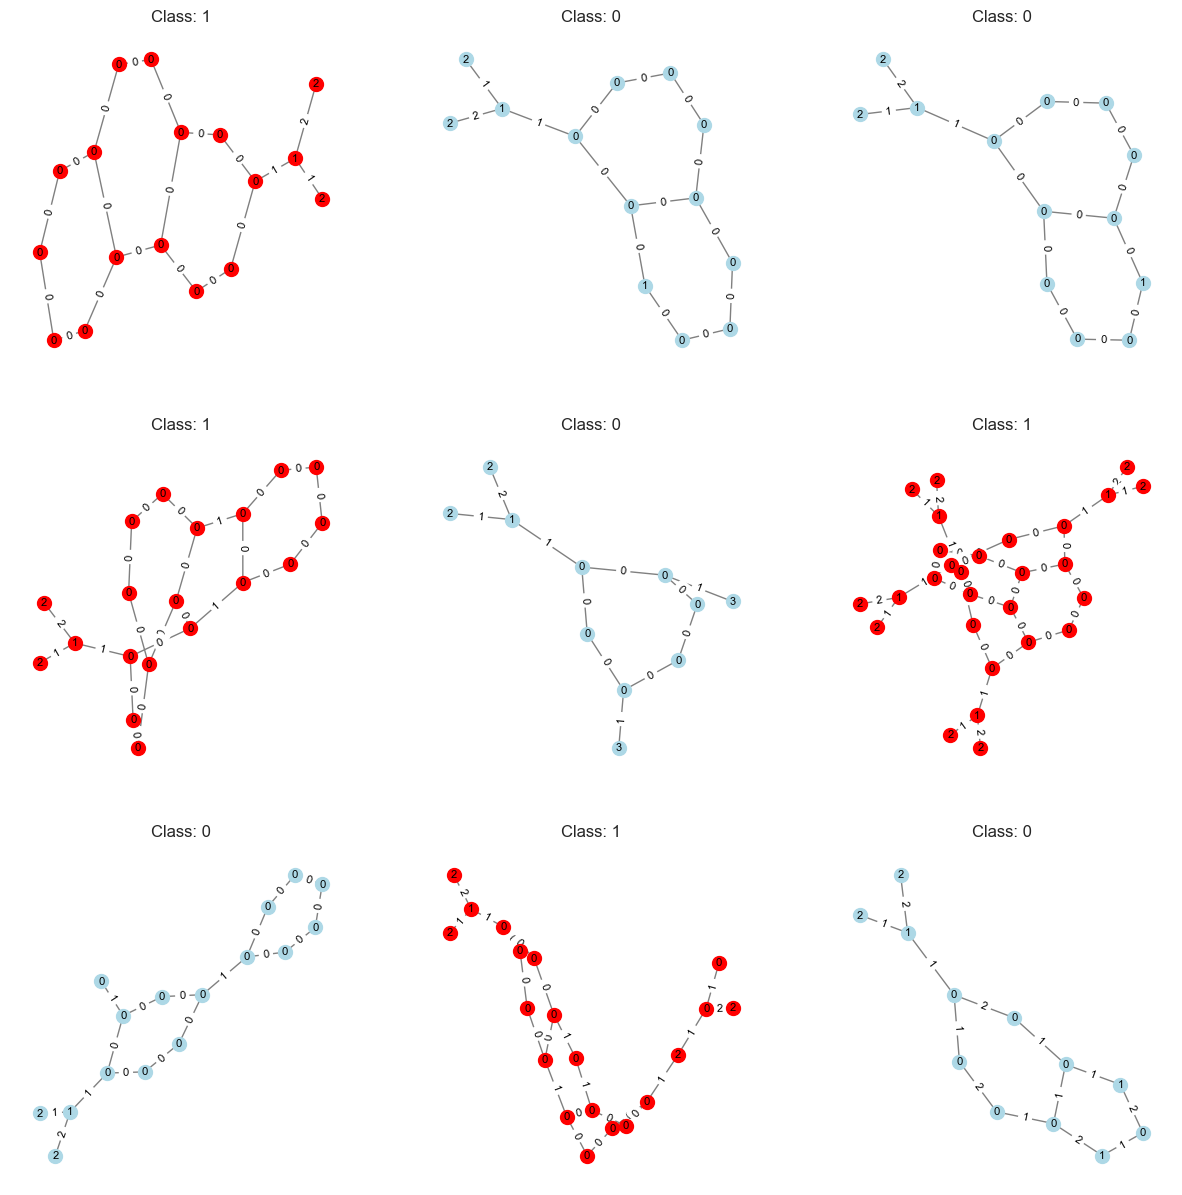

In [27]:
# View the dataset
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(9):
    # Draw with node colour and edge colour encoding node and edge types
    plot_graph(all_graphs[i], ax=ax[i//3, i%3])

fig.savefig(os.path.join(PLOT_PATH, "dataset.png"), dpi=300)

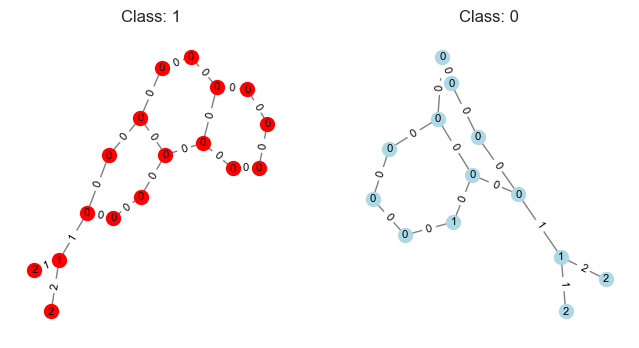

In [28]:
# Print positive vs. negative sample side-by-side
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
plot_graph(positive_graphs[0], ax=ax[0])
plot_graph(negative_graphs[0], ax=ax[1])

# Save figure
fig.savefig(os.path.join(PLOT_PATH, "pos_vs_neg.png"))

,MUTAG
#Graphs,188.00
Avg. #Nodes,17.93
Avg. #Edges,19.79
Avg. Degree,2.19
Full Connectivity,1.00
Positive Ratio,0.66


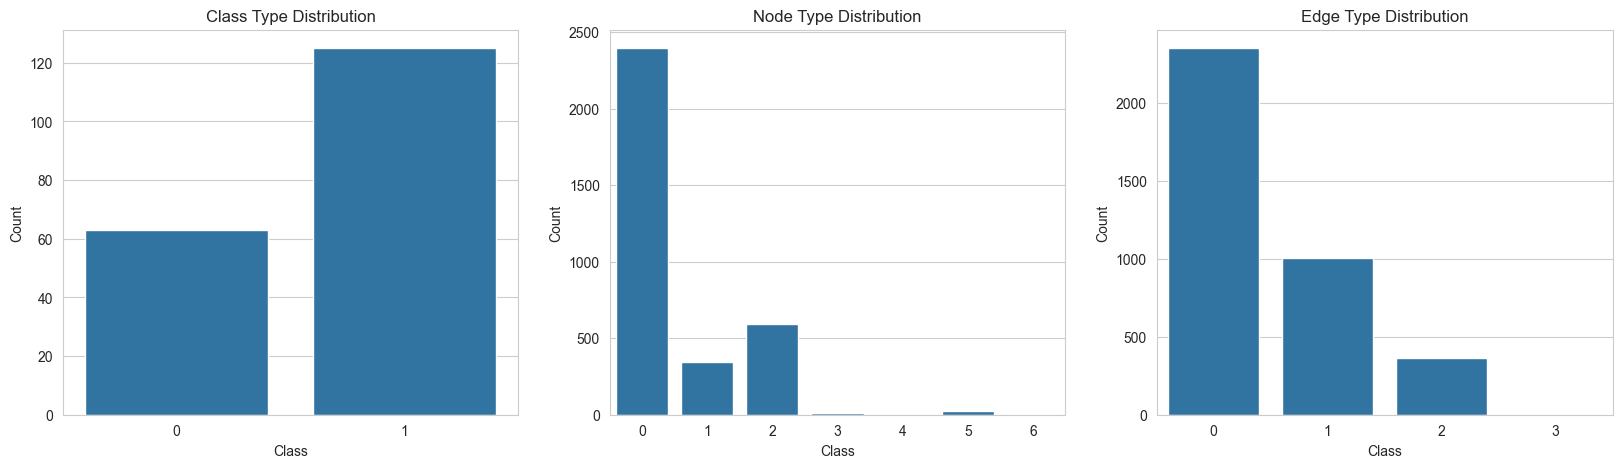

In [29]:
# Print some basic statistics about the dataset
statistics = compute_graph_statistics(all_graphs)

# Plot class, node type and edge type distribution
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
plot_categorical_dist(statistics["Classes"], ax=ax[0], title="Class Type Distribution")
plot_categorical_dist(statistics["Node Types"], ax=ax[1], title="Node Type Distribution")
plot_categorical_dist(statistics["Edge Types"], ax=ax[2], title="Edge Type Distribution")

# Save plot
fig.savefig(os.path.join(PLOT_PATH, "mutag_statistics.png"), dpi=300)

display_statistics(statistics, index=["MUTAG"])

,Positive,Negative
#Graphs,125.00,63.00
Avg. #Nodes,19.94,13.94
Avg. #Edges,22.40,14.62
Avg. Degree,2.24,2.09
Full Connectivity,1.00,1.00
Positive Ratio,1.00,0.00


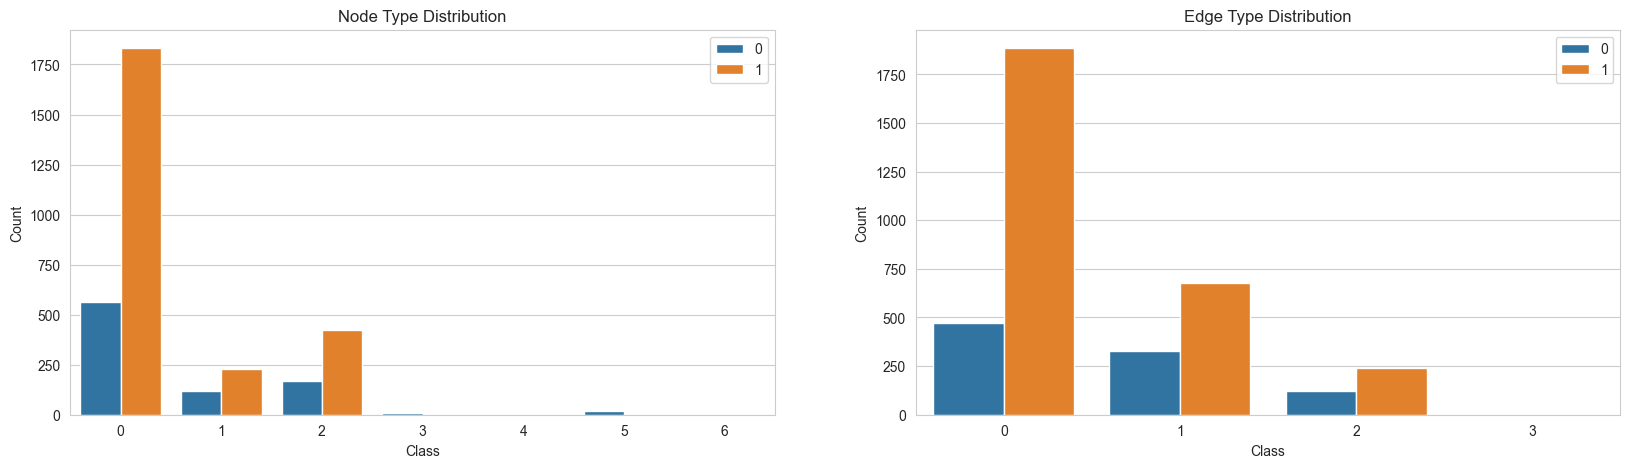

In [30]:
# Print some basic statistics about the positive and negative graphs
pos_statistics = compute_graph_statistics(positive_graphs)
neg_statistics = compute_graph_statistics(negative_graphs)

# Plot class, node type and edge type distribution
node_types = pos_statistics["Node Types"] + neg_statistics["Node Types"]
hue_node_types = [1] * len(pos_statistics["Node Types"]) + [0] * len(neg_statistics["Node Types"])
edge_types = pos_statistics["Edge Types"] + neg_statistics["Edge Types"]
hue_edge_types = [1] * len(pos_statistics["Edge Types"]) + [0] * len(neg_statistics["Edge Types"])

fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
plot_categorical_dist(node_types, hue=hue_node_types, ax=ax[0], title="Node Type Distribution")
plot_categorical_dist(edge_types, hue=hue_edge_types, ax=ax[1], title="Edge Type Distribution")

# Save plot
fig.savefig(os.path.join(PLOT_PATH, "pos_vs_neg_statistics.png"), dpi=300)

display_statistics(pos_statistics, neg_statistics, index=["Positive", "Negative"])

In [31]:
# Data splitting
n_val = int(0.15 * len(data))
n_test = int(0.15 * len(data))
n_train = len(data) - n_val - n_test
split_num_samples = [n_train, n_val, n_test]

# Split dataset randomly
train_data, val_data, test_data = random_split(data, split_num_samples)

In [32]:
# Quick EDA
train_statistics = compute_graph_statistics([convert_to_graph(train_graph) for train_graph in train_data])
val_statistics = compute_graph_statistics([convert_to_graph(val_graph) for val_graph in val_data])
test_statistics = compute_graph_statistics([convert_to_graph(test_graph) for test_graph in test_data])

display_statistics(train_statistics, val_statistics, test_statistics, index=["Train", "Validation", "Test"])

,Train,Validation,Test
#Graphs,132.00,28.00,28.00
Avg. #Nodes,17.88,18.04,18.07
Avg. #Edges,19.73,19.89,20.00
Avg. Degree,2.19,2.18,2.19
Full Connectivity,1.00,1.00,1.00
Positive Ratio,0.67,0.57,0.71


In [33]:
train_ratio = train_statistics["Positive Ratio"]
val_ratio = val_statistics["Positive Ratio"]
test_ratio = test_statistics["Positive Ratio"]

In [34]:
# Create data loaders
batch_size = 1
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

### Hyperparameter Tuning

This section trains graph neural networks in different configurations (hyperparameters). To do so, we first define a set of utility functions:

- `validate`: Computes relevant classification metrics of a trained model on a validation or test split
- `train_epoch`: Trains a model for one epoch on a training split
- `train`: Trains a model for a given number of epochs on a training split and evaluates the model on a validation split after each epoch
- `plot_training_history`: Plots the training and validation history of a model (loss and macro F1 score) for each epoch
- `build_grid`: Builds a grid of hyperparameters to be tested

In [35]:
def validate(model, data_loader, criterion, use_edges=False, verbose=False):
    """
    Test model on data split using common classification accuracy.

    Args:
        model (nn.Module): Model to be tested.
        data_loader (DataLoader): Data loader containing the data.
        criterion (nn.Module): Loss function to use.
        use_edges (boolean): Whether to use edge features or not.
        verbose (boolean): Whether to print classification report or not. (optional)

    Returns:
        dict: Dictionary containing the model's performance on the data.
    """
    model.eval()

    loss = 0.
    all_preds, all_targets = [], []
    for batch in data_loader:
        # Extract node features, edge features, adjacency matrix and labels
        node_feats, edges, adjs, labels = batch

        # Forward pass
        neighs = edges if use_edges else adjs
        logits = model(node_feats.squeeze(), neighs.squeeze())
        probs = F.sigmoid(logits)
        preds = probs.round()

        # Compute loss
        batch_loss = criterion(logits, labels.reshape(-1))
        loss += batch_loss.item()

        # Save predictions and targets for later
        all_preds.append(preds.item())
        all_targets.append(labels.item())

    # Compute classification metrics
    loss /= len(data_loader)
    acc = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, zero_division=0., average="macro")
    conf_matrix = confusion_matrix(all_targets, all_preds)

    # Print classification report (if verbose flag is set)
    if verbose:
        test_classification_report = classification_report(all_targets, all_preds, zero_division=0.)
        print(test_classification_report)

    return {
        "loss": loss,
        "accuracy": acc,
        "f1": f1,
        "confusion_matrix": conf_matrix,
    }

In [36]:
def train_epoch(model, data_loader, criterion, optimiser, use_edges=False):
    """
    Train model on training data using specified loss function and optimiser.

    Args:
        model (nn.Module): Model to be tested.
        data_loader (DataLoader): Data loader containing the training data.
        criterion (nn.Module): Loss function to be optimized.
        optimiser (nn.optim.Optimizer): Optimiser to use for training.
        use_edges (boolean): Whether to use edge features or not.

    Returns:
        tuple: Tuple containing the training loss and accuracy.
    """

    # Set model into training mode
    model.train()

    train_loss, train_acc, train_f1 = 0., 0., 0.
    for batch in data_loader:
        optimiser.zero_grad()

        # Extract data features
        node_feats, edges, adjs, labels = batch

        # Forward pass
        neighs = edges if use_edges else adjs
        logits = model(node_feats.squeeze(), neighs.squeeze())
        probs = F.sigmoid(logits)
        preds = probs.round()

        # Compute loss value and update weights
        batch_loss = criterion(logits, labels.reshape(-1))
        batch_loss.backward()
        optimiser.step()

        # Compute batch accuracy, f1
        labels, preds = labels.detach(), preds.detach()
        batch_acc = accuracy_score(labels, preds)
        batch_f1 = f1_score(labels, preds, zero_division=0., average="macro")

        # Update training loss and accuracy
        train_loss += batch_loss.item()
        train_acc += batch_acc.item()
        train_f1 += batch_f1.item()

    # Normalise training loss and acc
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    train_f1 /= len(data_loader)

    return {
        "loss": train_loss,
        "accuracy": train_acc,
        "f1": train_f1,
    }

In [37]:
# Training loop
def train(model, train_loader, val_loader, criterion, optimiser, epochs, use_edges=False, verbose=2):
    """
    Train model on training data using specified loss function and optimiser.

    Args:
        model (nn.Module): Model to be tested.
        train_loader (DataLoader): Data loader containing the trainin data.
        val_loader (DataLoader): Data loader containing the trainin data.
        criterion (nn.Module): Loss function to be optimized.
        optimiser (nn.optim.Optimizer): Optimiser to use for training.
        epochs (int): Number of epochs to train for.
        use_edges (boolean): Whether to use edge features or not.
        verbose (int): 0 for no output, 1 for tqdm progress, 2 for batch summaries. (optional)

    Returns:
        results (dict): Dictionary containing the model's final performance on the data training and validation data and history of loss and accuracy on both splits.
    """
    
    # Initialise training loss and accuracy
    metrics = ["train_loss", "train_acc", "train_f1", "val_loss", "val_acc", "val_f1"]
    history = {metric: [] for metric in metrics}
    pbar = tqdm(range(epochs), disable=verbose != 1)
    for epoch in pbar:
        # Train model
        train_results = train_epoch(model, train_loader, criterion, optimiser, use_edges=use_edges)
        train_loss = train_results["loss"]
        train_acc = train_results["accuracy"]
        train_f1 = train_results["f1"]

        # Validate model
        val_results = validate(model, val_loader, criterion, use_edges=use_edges)
        val_loss = val_results["loss"]
        val_acc = val_results["accuracy"]
        val_f1 = val_results["f1"]

        # Save training/ validation loss and accuracy
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_f1"].append(train_f1)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        progress= " | ".join([
            f"{epoch+1}/{epochs}",
            f"Train {train_loss:.4f} ({(100*train_acc):.1f}%)",
            f"Val {val_loss:.4f} ({(100*val_acc):.1f}%)"
        ])

        # Verbose output
        if verbose == 1:
            pbar.set_description(progress)
        elif verbose == 2:
            print(progress)

    results = {
        "train_results": {
            "loss": history["train_loss"][-1], 
            "accuracy": history["train_acc"][-1]},
            "f1": history["train_f1"][-1],
        "val_results": val_results,
        "history": history,
    }

    return results

In [71]:
def plot_training_history(train_results, kwargs={}):
    """
    Plots the training and validation loss (left subplot) and accuracy (right subplot) over the training epochs saved in the history dictionary.

    Args:
        history (dict): Dictionary containing the training and validation loss and accuracy.

    Returns:
        fig (matplotlib.pyplot.figure): Figure containing the training history plots (can be used for saving the figure)
    """
    
    # Create figure with two subplots
    fig, axs  = plt.subplots(ncols=3, figsize=(20, 4))

    # Extract history of train/val loss and accuracy
    history = train_results["history"]

    # Plot train/val loss
    sns.lineplot(history["train_loss"], label="Train Loss", ax=axs[0])
    sns.lineplot(history["val_loss"], label="Val Loss", ax=axs[0])

    # Plot train/val accuracy
    sns.lineplot(history["train_acc"], label="Train Acc", ax=axs[1])
    sns.lineplot(history["val_acc"], label="Val Acc", ax=axs[1])

    # Plot train/val f1
    sns.lineplot(history["train_f1"], label="Train -F1", ax=axs[2])
    sns.lineplot(history["val_f1"], label="Val F1", ax=axs[2])

    # Set plot labels
    for ax in axs:
        ax.set_xlabel("Epoch")
        ax.legend()
    axs[0].set_ylabel("Loss")
    axs[1].set_ylabel("Accuracy")
    axs[2].set_ylabel("F1")
    axs[1].set_ylim(0, 1)

    params = ",".join([f"{k}: {v}" for k, v in kwargs.items() if k != 'model'])
    fig.suptitle(f"Training History ({params})")

    return fig

In [39]:
def build_grid(hyperparams):
    """
    Builds a grid of hyperparameters to be tested.

    Args:
        hyperparams (dict): Dictionary of hyperparameters and their values and an iterable of values to test.

    Returns:
        list[dict]: List of hyperparameter combinations to test, each as dictionary of hyperparameter names and value. Length is the product of the number of values for each hyperparameter.
    """
    return [dict(zip(hyperparams.keys(), values)) for values in product(*hyperparams.values())]

For each hyperparameter, we define a set of values to try out. Then, we create a grid of all possible combinations of hyperparameters. For each combination, we train a model and evaluate it on the validation set and save the results in a dictionary in order to analyse the results later.

In [40]:
MODEL_HYPERPARAMS = {
    "num_features": [7],
    "num_layers": [3, 5, 7],
    "conv_dim": [8, 32, 64],
    "conv": [GraphConv, GraphSAGEConv, AttentionGraphConvolution],
    "pooling": [MeanPooling, MaxPooling],
}
TRAIN_HYPERPARAMS = {
    "learning_rate": [1e-2, 1e-3],
    "epochs": [100]
}

# Build grid
model_grid = build_grid(MODEL_HYPERPARAMS)
train_grid = build_grid(TRAIN_HYPERPARAMS)

print(f"Testing {len(model_grid)} model configurations for {len(train_grid)} training configurations. Total of {len(model_grid) * len(train_grid)} experiments.")

Testing 54 model configurations for 2 training configurations. Total of 108 experiments.


We run the experiments for the first three convolutional layers. The results are saved in the dictionary `RESULTS` and are be analysed in the next section.

In [41]:
# Run experiments
RESULTS = {}
for i, model_hyperparams in enumerate(model_grid):
    for j, train_hyperparams in enumerate(train_grid):
        model = GNN(**model_hyperparams)
        RESULTS[model.uuid] = EXPERIMENT_RESULTS = {}

        # Compute number of trainable parameters
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        # Save model and training hyperparameters (experiment meta information)
        params = {**model_hyperparams, **train_hyperparams, "num_params": num_params}

        print(f"\nModel [{i*len(train_grid)+(j+1)}/{len(model_grid) * len(train_grid)}]")
        print(pd.Series(params))

        # Create optimizer and loss
        optimiser = torch.optim.Adam(model.parameters(), lr=train_hyperparams["learning_rate"])
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([train_ratio]))

        # Train model
        start = time.time()
        train_results = train(model, train_loader, val_loader, criterion, optimiser, epochs=train_hyperparams["epochs"], use_edges=False, verbose=1)
        print(f"Training complete. ✅ ({(time.time() - start):.1f}s)")

        # Save model and training results
        EXPERIMENT_RESULTS["model"] = model
        EXPERIMENT_RESULTS["train_hyperparams"] = train_hyperparams
        EXPERIMENT_RESULTS["model_hyperparams"] = model_hyperparams
        EXPERIMENT_RESULTS["train_results"] = train_results["train_results"]
        EXPERIMENT_RESULTS["val_results"] = train_results["val_results"]
        EXPERIMENT_RESULTS["other"] = {"num_params": num_params}

        # Save training history plot, but don't display it inline
        fig = plot_training_history(train_results, kwargs={**model_hyperparams, **train_hyperparams})
        fig.savefig(os.path.join(PLOT_PATH, f"training_curve_{model.uuid}.png"))
        plt.close()


Model [1/108]
num_features               7
num_layers                 3
conv_dim                   8
conv               GraphConv
pooling          MeanPooling
learning_rate           0.01
epochs                   100
num_params               377
dtype: object


100/100 | Train 0.3321 (84.1%) | Val 0.5416 (71.4%): 100%|██████████| 100/100 [00:27<00:00,  3.63it/s]


Training complete. ✅ (27.6s)

Model [2/108]
num_features               7
num_layers                 3
conv_dim                   8
conv               GraphConv
pooling          MeanPooling
learning_rate            0.0
epochs                   100
num_params               377
dtype: object


100/100 | Train 0.3810 (81.1%) | Val 0.4819 (75.0%): 100%|██████████| 100/100 [00:27<00:00,  3.62it/s]


Training complete. ✅ (27.6s)

Model [3/108]
num_features              7
num_layers                3
conv_dim                  8
conv              GraphConv
pooling          MaxPooling
learning_rate          0.01
epochs                  100
num_params              377
dtype: object


100/100 | Train 0.3996 (79.5%) | Val 0.4226 (78.6%): 100%|██████████| 100/100 [00:29<00:00,  3.35it/s]


Training complete. ✅ (29.9s)

Model [4/108]
num_features              7
num_layers                3
conv_dim                  8
conv              GraphConv
pooling          MaxPooling
learning_rate           0.0
epochs                  100
num_params              377
dtype: object


100/100 | Train 0.3496 (78.8%) | Val 0.4799 (67.9%): 100%|██████████| 100/100 [00:29<00:00,  3.36it/s]


Training complete. ✅ (29.7s)

Model [5/108]
num_features                 7
num_layers                   3
conv_dim                     8
conv             GraphSAGEConv
pooling            MeanPooling
learning_rate             0.01
epochs                     100
num_params                 377
dtype: object


100/100 | Train 0.1853 (93.9%) | Val 0.2264 (89.3%): 100%|██████████| 100/100 [00:26<00:00,  3.83it/s]


Training complete. ✅ (26.1s)

Model [6/108]
num_features                 7
num_layers                   3
conv_dim                     8
conv             GraphSAGEConv
pooling            MeanPooling
learning_rate              0.0
epochs                     100
num_params                 377
dtype: object


100/100 | Train 0.3147 (83.3%) | Val 0.3569 (75.0%): 100%|██████████| 100/100 [00:26<00:00,  3.84it/s]


Training complete. ✅ (26.0s)

Model [7/108]
num_features                 7
num_layers                   3
conv_dim                     8
conv             GraphSAGEConv
pooling             MaxPooling
learning_rate             0.01
epochs                     100
num_params                 377
dtype: object


100/100 | Train 0.1379 (92.4%) | Val 0.4493 (85.7%): 100%|██████████| 100/100 [00:27<00:00,  3.58it/s]


Training complete. ✅ (27.9s)

Model [8/108]
num_features                 7
num_layers                   3
conv_dim                     8
conv             GraphSAGEConv
pooling             MaxPooling
learning_rate              0.0
epochs                     100
num_params                 377
dtype: object


100/100 | Train 0.1630 (93.2%) | Val 0.2734 (85.7%): 100%|██████████| 100/100 [00:27<00:00,  3.63it/s]


Training complete. ✅ (27.6s)

Model [9/108]
num_features                             7
num_layers                               3
conv_dim                                 8
conv             AttentionGraphConvolution
pooling                        MeanPooling
learning_rate                         0.01
epochs                                 100
num_params                             241
dtype: object


100/100 | Train 0.3811 (82.6%) | Val 0.4824 (75.0%): 100%|██████████| 100/100 [00:36<00:00,  2.74it/s]


Training complete. ✅ (36.4s)

Model [10/108]
num_features                             7
num_layers                               3
conv_dim                                 8
conv             AttentionGraphConvolution
pooling                        MeanPooling
learning_rate                          0.0
epochs                                 100
num_params                             241
dtype: object


100/100 | Train 0.3973 (76.5%) | Val 0.4859 (67.9%): 100%|██████████| 100/100 [00:36<00:00,  2.77it/s]


Training complete. ✅ (36.1s)

Model [11/108]
num_features                             7
num_layers                               3
conv_dim                                 8
conv             AttentionGraphConvolution
pooling                         MaxPooling
learning_rate                         0.01
epochs                                 100
num_params                             241
dtype: object


100/100 | Train 0.4011 (81.1%) | Val 0.5463 (64.3%): 100%|██████████| 100/100 [00:39<00:00,  2.50it/s]


Training complete. ✅ (40.0s)

Model [12/108]
num_features                             7
num_layers                               3
conv_dim                                 8
conv             AttentionGraphConvolution
pooling                         MaxPooling
learning_rate                          0.0
epochs                                 100
num_params                             241
dtype: object


100/100 | Train 0.4271 (77.3%) | Val 0.4216 (82.1%): 100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Training complete. ✅ (39.4s)

Model [13/108]
num_features               7
num_layers                 3
conv_dim                  32
conv               GraphConv
pooling          MeanPooling
learning_rate           0.01
epochs                   100
num_params              4577
dtype: object


100/100 | Train 0.3316 (83.3%) | Val 0.4695 (78.6%): 100%|██████████| 100/100 [00:27<00:00,  3.65it/s]


Training complete. ✅ (27.4s)

Model [14/108]
num_features               7
num_layers                 3
conv_dim                  32
conv               GraphConv
pooling          MeanPooling
learning_rate            0.0
epochs                   100
num_params              4577
dtype: object


100/100 | Train 0.3351 (84.8%) | Val 0.4628 (78.6%): 100%|██████████| 100/100 [00:27<00:00,  3.67it/s]


Training complete. ✅ (27.2s)

Model [15/108]
num_features              7
num_layers                3
conv_dim                 32
conv              GraphConv
pooling          MaxPooling
learning_rate          0.01
epochs                  100
num_params             4577
dtype: object


100/100 | Train 0.2303 (91.7%) | Val 0.8397 (78.6%): 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]


Training complete. ✅ (29.7s)

Model [16/108]
num_features              7
num_layers                3
conv_dim                 32
conv              GraphConv
pooling          MaxPooling
learning_rate           0.0
epochs                  100
num_params             4577
dtype: object


100/100 | Train 0.2695 (87.1%) | Val 0.5165 (78.6%): 100%|██████████| 100/100 [00:29<00:00,  3.35it/s]


Training complete. ✅ (29.8s)

Model [17/108]
num_features                 7
num_layers                   3
conv_dim                    32
conv             GraphSAGEConv
pooling            MeanPooling
learning_rate             0.01
epochs                     100
num_params                4577
dtype: object


100/100 | Train 0.1200 (93.9%) | Val 0.3158 (82.1%): 100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


Training complete. ✅ (25.5s)

Model [18/108]
num_features                 7
num_layers                   3
conv_dim                    32
conv             GraphSAGEConv
pooling            MeanPooling
learning_rate              0.0
epochs                     100
num_params                4577
dtype: object


100/100 | Train 0.1147 (93.9%) | Val 0.2490 (89.3%): 100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


Training complete. ✅ (25.5s)

Model [19/108]
num_features                 7
num_layers                   3
conv_dim                    32
conv             GraphSAGEConv
pooling             MaxPooling
learning_rate             0.01
epochs                     100
num_params                4577
dtype: object


100/100 | Train 0.0935 (94.7%) | Val 0.3294 (89.3%): 100%|██████████| 100/100 [00:27<00:00,  3.60it/s]


Training complete. ✅ (27.8s)

Model [20/108]
num_features                 7
num_layers                   3
conv_dim                    32
conv             GraphSAGEConv
pooling             MaxPooling
learning_rate              0.0
epochs                     100
num_params                4577
dtype: object


100/100 | Train 0.1121 (93.9%) | Val 0.3691 (82.1%): 100%|██████████| 100/100 [00:27<00:00,  3.60it/s]


Training complete. ✅ (27.8s)

Model [21/108]
num_features                             7
num_layers                               3
conv_dim                                32
conv             AttentionGraphConvolution
pooling                        MeanPooling
learning_rate                         0.01
epochs                                 100
num_params                            2497
dtype: object


100/100 | Train 0.4004 (78.0%) | Val 0.4481 (71.4%): 100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


Training complete. ✅ (45.3s)

Model [22/108]
num_features                             7
num_layers                               3
conv_dim                                32
conv             AttentionGraphConvolution
pooling                        MeanPooling
learning_rate                          0.0
epochs                                 100
num_params                            2497
dtype: object


100/100 | Train 0.3669 (83.3%) | Val 0.4643 (75.0%): 100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


Training complete. ✅ (91.5s)

Model [23/108]
num_features                             7
num_layers                               3
conv_dim                                32
conv             AttentionGraphConvolution
pooling                         MaxPooling
learning_rate                         0.01
epochs                                 100
num_params                            2497
dtype: object


100/100 | Train 0.4190 (78.0%) | Val 0.5399 (71.4%): 100%|██████████| 100/100 [14:55<00:00,  8.96s/it] 


Training complete. ✅ (895.7s)

Model [24/108]
num_features                             7
num_layers                               3
conv_dim                                32
conv             AttentionGraphConvolution
pooling                         MaxPooling
learning_rate                          0.0
epochs                                 100
num_params                            2497
dtype: object


100/100 | Train 0.3610 (78.8%) | Val 0.4748 (78.6%): 100%|██████████| 100/100 [15:42<00:00,  9.42s/it] 


Training complete. ✅ (942.2s)

Model [25/108]
num_features               7
num_layers                 3
conv_dim                  64
conv               GraphConv
pooling          MeanPooling
learning_rate           0.01
epochs                   100
num_params             17345
dtype: object


100/100 | Train 0.3252 (84.1%) | Val 0.4931 (78.6%): 100%|██████████| 100/100 [08:02<00:00,  4.83s/it]


Training complete. ✅ (483.0s)

Model [26/108]
num_features               7
num_layers                 3
conv_dim                  64
conv               GraphConv
pooling          MeanPooling
learning_rate            0.0
epochs                   100
num_params             17345
dtype: object


100/100 | Train 0.3239 (85.6%) | Val 0.4418 (78.6%): 100%|██████████| 100/100 [00:32<00:00,  3.10it/s]


Training complete. ✅ (32.2s)

Model [27/108]
num_features              7
num_layers                3
conv_dim                 64
conv              GraphConv
pooling          MaxPooling
learning_rate          0.01
epochs                  100
num_params            17345
dtype: object


100/100 | Train 0.4696 (78.8%) | Val 0.5265 (71.4%): 100%|██████████| 100/100 [00:32<00:00,  3.09it/s]


Training complete. ✅ (32.4s)

Model [28/108]
num_features              7
num_layers                3
conv_dim                 64
conv              GraphConv
pooling          MaxPooling
learning_rate           0.0
epochs                  100
num_params            17345
dtype: object


100/100 | Train 0.1771 (93.2%) | Val 0.5343 (85.7%): 100%|██████████| 100/100 [00:31<00:00,  3.19it/s]


Training complete. ✅ (31.3s)

Model [29/108]
num_features                 7
num_layers                   3
conv_dim                    64
conv             GraphSAGEConv
pooling            MeanPooling
learning_rate             0.01
epochs                     100
num_params               17345
dtype: object


100/100 | Train 0.2283 (90.9%) | Val 0.3279 (89.3%): 100%|██████████| 100/100 [00:27<00:00,  3.66it/s]


Training complete. ✅ (27.3s)

Model [30/108]
num_features                 7
num_layers                   3
conv_dim                    64
conv             GraphSAGEConv
pooling            MeanPooling
learning_rate              0.0
epochs                     100
num_params               17345
dtype: object


100/100 | Train 0.1137 (93.2%) | Val 0.2466 (89.3%): 100%|██████████| 100/100 [00:27<00:00,  3.67it/s]


Training complete. ✅ (27.2s)

Model [31/108]
num_features                 7
num_layers                   3
conv_dim                    64
conv             GraphSAGEConv
pooling             MaxPooling
learning_rate             0.01
epochs                     100
num_params               17345
dtype: object


100/100 | Train 0.4064 (87.9%) | Val 0.3308 (82.1%): 100%|██████████| 100/100 [00:29<00:00,  3.41it/s]


Training complete. ✅ (29.4s)

Model [32/108]
num_features                 7
num_layers                   3
conv_dim                    64
conv             GraphSAGEConv
pooling             MaxPooling
learning_rate              0.0
epochs                     100
num_params               17345
dtype: object


100/100 | Train 0.0432 (98.5%) | Val 0.4337 (75.0%): 100%|██████████| 100/100 [00:29<00:00,  3.36it/s]


Training complete. ✅ (29.8s)

Model [33/108]
num_features                             7
num_layers                               3
conv_dim                                64
conv             AttentionGraphConvolution
pooling                        MeanPooling
learning_rate                         0.01
epochs                                 100
num_params                            9089
dtype: object


100/100 | Train 0.4233 (75.8%) | Val 0.5207 (71.4%): 100%|██████████| 100/100 [00:53<00:00,  1.89it/s]


Training complete. ✅ (53.0s)

Model [34/108]
num_features                             7
num_layers                               3
conv_dim                                64
conv             AttentionGraphConvolution
pooling                        MeanPooling
learning_rate                          0.0
epochs                                 100
num_params                            9089
dtype: object


100/100 | Train 0.3565 (81.8%) | Val 0.4827 (75.0%): 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


Training complete. ✅ (53.6s)

Model [35/108]
num_features                             7
num_layers                               3
conv_dim                                64
conv             AttentionGraphConvolution
pooling                         MaxPooling
learning_rate                         0.01
epochs                                 100
num_params                            9089
dtype: object


100/100 | Train 0.3909 (76.5%) | Val 0.5410 (75.0%): 100%|██████████| 100/100 [00:51<00:00,  1.92it/s]


Training complete. ✅ (52.0s)

Model [36/108]
num_features                             7
num_layers                               3
conv_dim                                64
conv             AttentionGraphConvolution
pooling                         MaxPooling
learning_rate                          0.0
epochs                                 100
num_params                            9089
dtype: object


100/100 | Train 0.3062 (84.1%) | Val 0.4897 (78.6%): 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Training complete. ✅ (51.9s)

Model [37/108]
num_features               7
num_layers                 5
conv_dim                   8
conv               GraphConv
pooling          MeanPooling
learning_rate           0.01
epochs                   100
num_params               633
dtype: object


100/100 | Train 0.2918 (88.6%) | Val 0.4964 (78.6%): 100%|██████████| 100/100 [00:30<00:00,  3.29it/s]


Training complete. ✅ (30.4s)

Model [38/108]
num_features               7
num_layers                 5
conv_dim                   8
conv               GraphConv
pooling          MeanPooling
learning_rate            0.0
epochs                   100
num_params               633
dtype: object


100/100 | Train 0.3469 (82.6%) | Val 0.4482 (75.0%): 100%|██████████| 100/100 [00:30<00:00,  3.26it/s]


Training complete. ✅ (30.7s)

Model [39/108]
num_features              7
num_layers                5
conv_dim                  8
conv              GraphConv
pooling          MaxPooling
learning_rate          0.01
epochs                  100
num_params              633
dtype: object


100/100 | Train 0.1951 (93.2%) | Val 0.5441 (78.6%): 100%|██████████| 100/100 [00:32<00:00,  3.08it/s]


Training complete. ✅ (32.5s)

Model [40/108]
num_features              7
num_layers                5
conv_dim                  8
conv              GraphConv
pooling          MaxPooling
learning_rate           0.0
epochs                  100
num_params              633
dtype: object


100/100 | Train 0.3331 (83.3%) | Val 0.4318 (78.6%): 100%|██████████| 100/100 [00:32<00:00,  3.10it/s]


Training complete. ✅ (32.2s)

Model [41/108]
num_features                 7
num_layers                   5
conv_dim                     8
conv             GraphSAGEConv
pooling            MeanPooling
learning_rate             0.01
epochs                     100
num_params                 633
dtype: object


100/100 | Train 0.2235 (86.4%) | Val 0.3641 (85.7%): 100%|██████████| 100/100 [00:26<00:00,  3.72it/s]


Training complete. ✅ (26.9s)

Model [42/108]
num_features                 7
num_layers                   5
conv_dim                     8
conv             GraphSAGEConv
pooling            MeanPooling
learning_rate              0.0
epochs                     100
num_params                 633
dtype: object


100/100 | Train 0.1959 (87.9%) | Val 0.2788 (85.7%): 100%|██████████| 100/100 [00:26<00:00,  3.72it/s]


Training complete. ✅ (26.9s)

Model [43/108]
num_features                 7
num_layers                   5
conv_dim                     8
conv             GraphSAGEConv
pooling             MaxPooling
learning_rate             0.01
epochs                     100
num_params                 633
dtype: object


100/100 | Train 0.2124 (87.9%) | Val 0.3525 (89.3%): 100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


Training complete. ✅ (31.1s)

Model [44/108]
num_features                 7
num_layers                   5
conv_dim                     8
conv             GraphSAGEConv
pooling             MaxPooling
learning_rate              0.0
epochs                     100
num_params                 633
dtype: object


100/100 | Train 0.2300 (87.1%) | Val 0.3016 (75.0%): 100%|██████████| 100/100 [00:29<00:00,  3.42it/s]


Training complete. ✅ (29.3s)

Model [45/108]
num_features                             7
num_layers                               5
conv_dim                                 8
conv             AttentionGraphConvolution
pooling                        MeanPooling
learning_rate                         0.01
epochs                                 100
num_params                             401
dtype: object


100/100 | Train 0.3993 (77.3%) | Val 0.5137 (75.0%): 100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


Training complete. ✅ (44.6s)

Model [46/108]
num_features                             7
num_layers                               5
conv_dim                                 8
conv             AttentionGraphConvolution
pooling                        MeanPooling
learning_rate                          0.0
epochs                                 100
num_params                             401
dtype: object


100/100 | Train 0.3816 (77.3%) | Val 0.4727 (71.4%): 100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


Training complete. ✅ (44.6s)

Model [47/108]
num_features                             7
num_layers                               5
conv_dim                                 8
conv             AttentionGraphConvolution
pooling                         MaxPooling
learning_rate                         0.01
epochs                                 100
num_params                             401
dtype: object


100/100 | Train 0.3696 (78.8%) | Val 0.5113 (67.9%): 100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Training complete. ✅ (46.5s)

Model [48/108]
num_features                             7
num_layers                               5
conv_dim                                 8
conv             AttentionGraphConvolution
pooling                         MaxPooling
learning_rate                          0.0
epochs                                 100
num_params                             401
dtype: object


100/100 | Train 0.3715 (82.6%) | Val 0.4764 (78.6%): 100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


Training complete. ✅ (46.7s)

Model [49/108]
num_features               7
num_layers                 5
conv_dim                  32
conv               GraphConv
pooling          MeanPooling
learning_rate           0.01
epochs                   100
num_params              8673
dtype: object


100/100 | Train 0.3410 (84.1%) | Val 0.4889 (75.0%): 100%|██████████| 100/100 [00:31<00:00,  3.15it/s]


Training complete. ✅ (31.8s)

Model [50/108]
num_features               7
num_layers                 5
conv_dim                  32
conv               GraphConv
pooling          MeanPooling
learning_rate            0.0
epochs                   100
num_params              8673
dtype: object


100/100 | Train 0.2314 (89.4%) | Val 0.5828 (75.0%): 100%|██████████| 100/100 [00:31<00:00,  3.14it/s]


Training complete. ✅ (31.8s)

Model [51/108]
num_features              7
num_layers                5
conv_dim                 32
conv              GraphConv
pooling          MaxPooling
learning_rate          0.01
epochs                  100
num_params             8673
dtype: object


100/100 | Train 0.3515 (84.8%) | Val 0.5163 (75.0%): 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


Training complete. ✅ (33.9s)

Model [52/108]
num_features              7
num_layers                5
conv_dim                 32
conv              GraphConv
pooling          MaxPooling
learning_rate           0.0
epochs                  100
num_params             8673
dtype: object


100/100 | Train 0.2366 (88.6%) | Val 0.4099 (82.1%): 100%|██████████| 100/100 [00:34<00:00,  2.94it/s]


Training complete. ✅ (34.0s)

Model [53/108]
num_features                 7
num_layers                   5
conv_dim                    32
conv             GraphSAGEConv
pooling            MeanPooling
learning_rate             0.01
epochs                     100
num_params                8673
dtype: object


100/100 | Train 0.1907 (92.4%) | Val 0.3425 (89.3%): 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


Training complete. ✅ (28.5s)

Model [54/108]
num_features                 7
num_layers                   5
conv_dim                    32
conv             GraphSAGEConv
pooling            MeanPooling
learning_rate              0.0
epochs                     100
num_params                8673
dtype: object


100/100 | Train 0.0643 (97.0%) | Val 0.2904 (85.7%): 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]


Training complete. ✅ (28.5s)

Model [55/108]
num_features                 7
num_layers                   5
conv_dim                    32
conv             GraphSAGEConv
pooling             MaxPooling
learning_rate             0.01
epochs                     100
num_params                8673
dtype: object


100/100 | Train 10.3776 (70.5%) | Val 0.6605 (78.6%): 100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


Training complete. ✅ (31.0s)

Model [56/108]
num_features                 7
num_layers                   5
conv_dim                    32
conv             GraphSAGEConv
pooling             MaxPooling
learning_rate              0.0
epochs                     100
num_params                8673
dtype: object


100/100 | Train 0.0505 (97.7%) | Val 0.5239 (89.3%): 100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Training complete. ✅ (31.1s)

Model [57/108]
num_features                             7
num_layers                               5
conv_dim                                32
conv             AttentionGraphConvolution
pooling                        MeanPooling
learning_rate                         0.01
epochs                                 100
num_params                            4673
dtype: object


100/100 | Train 0.4221 (75.8%) | Val 0.4797 (67.9%): 100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


Training complete. ✅ (54.1s)

Model [58/108]
num_features                             7
num_layers                               5
conv_dim                                32
conv             AttentionGraphConvolution
pooling                        MeanPooling
learning_rate                          0.0
epochs                                 100
num_params                            4673
dtype: object


100/100 | Train 0.3477 (84.1%) | Val 0.5032 (71.4%): 100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Training complete. ✅ (54.5s)

Model [59/108]
num_features                             7
num_layers                               5
conv_dim                                32
conv             AttentionGraphConvolution
pooling                         MaxPooling
learning_rate                         0.01
epochs                                 100
num_params                            4673
dtype: object


100/100 | Train 0.3990 (77.3%) | Val 0.4684 (75.0%): 100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


Training complete. ✅ (56.2s)

Model [60/108]
num_features                             7
num_layers                               5
conv_dim                                32
conv             AttentionGraphConvolution
pooling                         MaxPooling
learning_rate                          0.0
epochs                                 100
num_params                            4673
dtype: object


100/100 | Train 0.3043 (83.3%) | Val 0.4845 (71.4%): 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Training complete. ✅ (55.7s)

Model [61/108]
num_features               7
num_layers                 5
conv_dim                  64
conv               GraphConv
pooling          MeanPooling
learning_rate           0.01
epochs                   100
num_params             33729
dtype: object


100/100 | Train 0.3411 (84.8%) | Val 0.5195 (67.9%): 100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


Training complete. ✅ (32.8s)

Model [62/108]
num_features               7
num_layers                 5
conv_dim                  64
conv               GraphConv
pooling          MeanPooling
learning_rate            0.0
epochs                   100
num_params             33729
dtype: object


100/100 | Train 0.1858 (93.2%) | Val 0.6722 (75.0%): 100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


Training complete. ✅ (32.8s)

Model [63/108]
num_features              7
num_layers                5
conv_dim                 64
conv              GraphConv
pooling          MaxPooling
learning_rate          0.01
epochs                  100
num_params            33729
dtype: object


100/100 | Train 1.5074 (65.2%) | Val 1.3177 (57.1%): 100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


Training complete. ✅ (35.5s)

Model [64/108]
num_features              7
num_layers                5
conv_dim                 64
conv              GraphConv
pooling          MaxPooling
learning_rate           0.0
epochs                  100
num_params            33729
dtype: object


100/100 | Train 0.1455 (93.2%) | Val 0.9128 (71.4%): 100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


Training complete. ✅ (35.5s)

Model [65/108]
num_features                 7
num_layers                   5
conv_dim                    64
conv             GraphSAGEConv
pooling            MeanPooling
learning_rate             0.01
epochs                     100
num_params               33729
dtype: object


100/100 | Train 5.3388 (65.9%) | Val 0.3859 (75.0%): 100%|██████████| 100/100 [00:30<00:00,  3.26it/s]


Training complete. ✅ (30.6s)

Model [66/108]
num_features                 7
num_layers                   5
conv_dim                    64
conv             GraphSAGEConv
pooling            MeanPooling
learning_rate              0.0
epochs                     100
num_params               33729
dtype: object


100/100 | Train 0.0026 (100.0%) | Val 0.5003 (89.3%): 100%|██████████| 100/100 [00:31<00:00,  3.23it/s]


Training complete. ✅ (31.0s)

Model [67/108]
num_features                 7
num_layers                   5
conv_dim                    64
conv             GraphSAGEConv
pooling             MaxPooling
learning_rate             0.01
epochs                     100
num_params               33729
dtype: object


100/100 | Train 1.0377 (73.5%) | Val 0.7348 (71.4%): 100%|██████████| 100/100 [00:33<00:00,  3.00it/s] 


Training complete. ✅ (33.3s)

Model [68/108]
num_features                 7
num_layers                   5
conv_dim                    64
conv             GraphSAGEConv
pooling             MaxPooling
learning_rate              0.0
epochs                     100
num_params               33729
dtype: object


100/100 | Train 0.0001 (100.0%) | Val 0.5583 (92.9%): 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


Training complete. ✅ (33.3s)

Model [69/108]
num_features                             7
num_layers                               5
conv_dim                                64
conv             AttentionGraphConvolution
pooling                        MeanPooling
learning_rate                         0.01
epochs                                 100
num_params                           17537
dtype: object


100/100 | Train 0.4937 (71.2%) | Val 0.6311 (53.6%): 100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Training complete. ✅ (66.3s)

Model [70/108]
num_features                             7
num_layers                               5
conv_dim                                64
conv             AttentionGraphConvolution
pooling                        MeanPooling
learning_rate                          0.0
epochs                                 100
num_params                           17537
dtype: object


100/100 | Train 0.3494 (83.3%) | Val 0.5001 (75.0%): 100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


Training complete. ✅ (66.5s)

Model [71/108]
num_features                             7
num_layers                               5
conv_dim                                64
conv             AttentionGraphConvolution
pooling                         MaxPooling
learning_rate                         0.01
epochs                                 100
num_params                           17537
dtype: object


100/100 | Train 0.3746 (80.3%) | Val 0.5321 (67.9%): 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


Training complete. ✅ (68.4s)

Model [72/108]
num_features                             7
num_layers                               5
conv_dim                                64
conv             AttentionGraphConvolution
pooling                         MaxPooling
learning_rate                          0.0
epochs                                 100
num_params                           17537
dtype: object


100/100 | Train 0.3044 (83.3%) | Val 0.5003 (75.0%): 100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Training complete. ✅ (67.6s)

Model [73/108]
num_features               7
num_layers                 7
conv_dim                   8
conv               GraphConv
pooling          MeanPooling
learning_rate           0.01
epochs                   100
num_params               889
dtype: object


100/100 | Train 0.3733 (80.3%) | Val 0.4879 (75.0%): 100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


Training complete. ✅ (33.5s)

Model [74/108]
num_features               7
num_layers                 7
conv_dim                   8
conv               GraphConv
pooling          MeanPooling
learning_rate            0.0
epochs                   100
num_params               889
dtype: object


100/100 | Train 0.3226 (83.3%) | Val 0.4682 (78.6%): 100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


Training complete. ✅ (33.3s)

Model [75/108]
num_features              7
num_layers                7
conv_dim                  8
conv              GraphConv
pooling          MaxPooling
learning_rate          0.01
epochs                  100
num_params              889
dtype: object


100/100 | Train 0.3588 (85.6%) | Val 0.4310 (71.4%): 100%|██████████| 100/100 [00:35<00:00,  2.80it/s]


Training complete. ✅ (35.7s)

Model [76/108]
num_features              7
num_layers                7
conv_dim                  8
conv              GraphConv
pooling          MaxPooling
learning_rate           0.0
epochs                  100
num_params              889
dtype: object


100/100 | Train 0.3718 (81.8%) | Val 0.5247 (75.0%): 100%|██████████| 100/100 [00:38<00:00,  2.62it/s]


Training complete. ✅ (38.2s)

Model [77/108]
num_features                 7
num_layers                   7
conv_dim                     8
conv             GraphSAGEConv
pooling            MeanPooling
learning_rate             0.01
epochs                     100
num_params                 889
dtype: object


100/100 | Train 0.2275 (87.1%) | Val 0.3362 (78.6%): 100%|██████████| 100/100 [00:31<00:00,  3.19it/s]


Training complete. ✅ (31.3s)

Model [78/108]
num_features                 7
num_layers                   7
conv_dim                     8
conv             GraphSAGEConv
pooling            MeanPooling
learning_rate              0.0
epochs                     100
num_params                 889
dtype: object


100/100 | Train 0.1904 (90.2%) | Val 0.2712 (85.7%): 100%|██████████| 100/100 [00:29<00:00,  3.43it/s]


Training complete. ✅ (29.2s)

Model [79/108]
num_features                 7
num_layers                   7
conv_dim                     8
conv             GraphSAGEConv
pooling             MaxPooling
learning_rate             0.01
epochs                     100
num_params                 889
dtype: object


100/100 | Train 0.2869 (82.6%) | Val 0.2952 (82.1%): 100%|██████████| 100/100 [00:31<00:00,  3.14it/s]


Training complete. ✅ (31.9s)

Model [80/108]
num_features                 7
num_layers                   7
conv_dim                     8
conv             GraphSAGEConv
pooling             MaxPooling
learning_rate              0.0
epochs                     100
num_params                 889
dtype: object


100/100 | Train 0.1286 (93.9%) | Val 0.2833 (85.7%): 100%|██████████| 100/100 [00:32<00:00,  3.03it/s]


Training complete. ✅ (33.0s)

Model [81/108]
num_features                             7
num_layers                               7
conv_dim                                 8
conv             AttentionGraphConvolution
pooling                        MeanPooling
learning_rate                         0.01
epochs                                 100
num_params                             561
dtype: object


100/100 | Train 0.4251 (79.5%) | Val 0.4958 (71.4%): 100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Training complete. ✅ (54.7s)

Model [82/108]
num_features                             7
num_layers                               7
conv_dim                                 8
conv             AttentionGraphConvolution
pooling                        MeanPooling
learning_rate                          0.0
epochs                                 100
num_params                             561
dtype: object


100/100 | Train 0.3887 (78.8%) | Val 0.4258 (71.4%): 100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


Training complete. ✅ (54.3s)

Model [83/108]
num_features                             7
num_layers                               7
conv_dim                                 8
conv             AttentionGraphConvolution
pooling                         MaxPooling
learning_rate                         0.01
epochs                                 100
num_params                             561
dtype: object


100/100 | Train 0.4018 (80.3%) | Val 0.5600 (67.9%): 100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


Training complete. ✅ (56.4s)

Model [84/108]
num_features                             7
num_layers                               7
conv_dim                                 8
conv             AttentionGraphConvolution
pooling                         MaxPooling
learning_rate                          0.0
epochs                                 100
num_params                             561
dtype: object


100/100 | Train 0.3582 (80.3%) | Val 0.5215 (64.3%): 100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


Training complete. ✅ (57.9s)

Model [85/108]
num_features               7
num_layers                 7
conv_dim                  32
conv               GraphConv
pooling          MeanPooling
learning_rate           0.01
epochs                   100
num_params             12769
dtype: object


100/100 | Train 0.3737 (81.8%) | Val 0.4509 (78.6%): 100%|██████████| 100/100 [00:33<00:00,  2.97it/s]


Training complete. ✅ (33.7s)

Model [86/108]
num_features               7
num_layers                 7
conv_dim                  32
conv               GraphConv
pooling          MeanPooling
learning_rate            0.0
epochs                   100
num_params             12769
dtype: object


100/100 | Train 0.2580 (88.6%) | Val 0.4096 (85.7%): 100%|██████████| 100/100 [00:33<00:00,  2.97it/s]


Training complete. ✅ (33.6s)

Model [87/108]
num_features              7
num_layers                7
conv_dim                 32
conv              GraphConv
pooling          MaxPooling
learning_rate          0.01
epochs                  100
num_params            12769
dtype: object


100/100 | Train 0.3137 (86.4%) | Val 0.4880 (75.0%): 100%|██████████| 100/100 [00:36<00:00,  2.73it/s]


Training complete. ✅ (36.7s)

Model [88/108]
num_features              7
num_layers                7
conv_dim                 32
conv              GraphConv
pooling          MaxPooling
learning_rate           0.0
epochs                  100
num_params            12769
dtype: object


100/100 | Train 0.1323 (95.5%) | Val 0.6680 (78.6%): 100%|██████████| 100/100 [00:36<00:00,  2.70it/s]


Training complete. ✅ (37.0s)

Model [89/108]
num_features                 7
num_layers                   7
conv_dim                    32
conv             GraphSAGEConv
pooling            MeanPooling
learning_rate             0.01
epochs                     100
num_params               12769
dtype: object


100/100 | Train 0.6018 (77.3%) | Val 0.5155 (78.6%): 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]  


Training complete. ✅ (30.2s)

Model [90/108]
num_features                 7
num_layers                   7
conv_dim                    32
conv             GraphSAGEConv
pooling            MeanPooling
learning_rate              0.0
epochs                     100
num_params               12769
dtype: object


100/100 | Train 0.1082 (95.5%) | Val 0.4357 (82.1%): 100%|██████████| 100/100 [00:29<00:00,  3.34it/s]


Training complete. ✅ (30.0s)

Model [91/108]
num_features                 7
num_layers                   7
conv_dim                    32
conv             GraphSAGEConv
pooling             MaxPooling
learning_rate             0.01
epochs                     100
num_params               12769
dtype: object


100/100 | Train 0.5146 (62.9%) | Val 0.5040 (57.1%): 100%|██████████| 100/100 [00:32<00:00,  3.06it/s]  


Training complete. ✅ (32.7s)

Model [92/108]
num_features                 7
num_layers                   7
conv_dim                    32
conv             GraphSAGEConv
pooling             MaxPooling
learning_rate              0.0
epochs                     100
num_params               12769
dtype: object


100/100 | Train 0.0403 (97.7%) | Val 0.4088 (89.3%): 100%|██████████| 100/100 [00:32<00:00,  3.07it/s]


Training complete. ✅ (32.6s)

Model [93/108]
num_features                             7
num_layers                               7
conv_dim                                32
conv             AttentionGraphConvolution
pooling                        MeanPooling
learning_rate                         0.01
epochs                                 100
num_params                            6849
dtype: object


100/100 | Train 0.4302 (75.0%) | Val 0.5359 (67.9%): 100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


Training complete. ✅ (65.4s)

Model [94/108]
num_features                             7
num_layers                               7
conv_dim                                32
conv             AttentionGraphConvolution
pooling                        MeanPooling
learning_rate                          0.0
epochs                                 100
num_params                            6849
dtype: object


100/100 | Train 0.3456 (83.3%) | Val 0.5134 (71.4%): 100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Training complete. ✅ (66.0s)

Model [95/108]
num_features                             7
num_layers                               7
conv_dim                                32
conv             AttentionGraphConvolution
pooling                         MaxPooling
learning_rate                         0.01
epochs                                 100
num_params                            6849
dtype: object


100/100 | Train 0.5121 (68.2%) | Val 0.5702 (60.7%): 100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


Training complete. ✅ (80.9s)

Model [96/108]
num_features                             7
num_layers                               7
conv_dim                                32
conv             AttentionGraphConvolution
pooling                         MaxPooling
learning_rate                          0.0
epochs                                 100
num_params                            6849
dtype: object


100/100 | Train 0.3349 (81.8%) | Val 0.5280 (64.3%): 100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


Training complete. ✅ (80.7s)

Model [97/108]
num_features               7
num_layers                 7
conv_dim                  64
conv               GraphConv
pooling          MeanPooling
learning_rate           0.01
epochs                   100
num_params             50113
dtype: object


100/100 | Train 5.8597 (60.6%) | Val 7.0505 (57.1%): 100%|██████████| 100/100 [00:43<00:00,  2.32it/s]    


Training complete. ✅ (43.1s)

Model [98/108]
num_features               7
num_layers                 7
conv_dim                  64
conv               GraphConv
pooling          MeanPooling
learning_rate            0.0
epochs                   100
num_params             50113
dtype: object


100/100 | Train 0.1245 (97.0%) | Val 1.3008 (75.0%): 100%|██████████| 100/100 [00:36<00:00,  2.70it/s]


Training complete. ✅ (37.0s)

Model [99/108]
num_features              7
num_layers                7
conv_dim                 64
conv              GraphConv
pooling          MaxPooling
learning_rate          0.01
epochs                  100
num_params            50113
dtype: object


100/100 | Train 0.5752 (56.1%) | Val 0.8443 (57.1%): 100%|██████████| 100/100 [00:42<00:00,  2.33it/s] 


Training complete. ✅ (42.8s)

Model [100/108]
num_features              7
num_layers                7
conv_dim                 64
conv              GraphConv
pooling          MaxPooling
learning_rate           0.0
epochs                  100
num_params            50113
dtype: object


100/100 | Train 0.1187 (93.9%) | Val 0.6083 (71.4%): 100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Training complete. ✅ (40.3s)

Model [101/108]
num_features                 7
num_layers                   7
conv_dim                    64
conv             GraphSAGEConv
pooling            MeanPooling
learning_rate             0.01
epochs                     100
num_params               50113
dtype: object


100/100 | Train 11.7520 (77.3%) | Val 26.1095 (60.7%): 100%|██████████| 100/100 [00:34<00:00,  2.91it/s]     


Training complete. ✅ (34.4s)

Model [102/108]
num_features                 7
num_layers                   7
conv_dim                    64
conv             GraphSAGEConv
pooling            MeanPooling
learning_rate              0.0
epochs                     100
num_params               50113
dtype: object


100/100 | Train 0.1106 (94.7%) | Val 0.2215 (85.7%): 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


Training complete. ✅ (33.3s)

Model [103/108]
num_features                 7
num_layers                   7
conv_dim                    64
conv             GraphSAGEConv
pooling             MaxPooling
learning_rate             0.01
epochs                     100
num_params               50113
dtype: object


100/100 | Train 21.4111 (70.5%) | Val 4.1602 (78.6%): 100%|██████████| 100/100 [00:35<00:00,  2.80it/s]    


Training complete. ✅ (35.7s)

Model [104/108]
num_features                 7
num_layers                   7
conv_dim                    64
conv             GraphSAGEConv
pooling             MaxPooling
learning_rate              0.0
epochs                     100
num_params               50113
dtype: object


100/100 | Train 0.1709 (92.4%) | Val 0.3826 (78.6%): 100%|██████████| 100/100 [00:35<00:00,  2.80it/s]


Training complete. ✅ (35.7s)

Model [105/108]
num_features                             7
num_layers                               7
conv_dim                                64
conv             AttentionGraphConvolution
pooling                        MeanPooling
learning_rate                         0.01
epochs                                 100
num_params                           25985
dtype: object


100/100 | Train 0.4837 (70.5%) | Val 0.4888 (67.9%): 100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


Training complete. ✅ (82.6s)

Model [106/108]
num_features                             7
num_layers                               7
conv_dim                                64
conv             AttentionGraphConvolution
pooling                        MeanPooling
learning_rate                          0.0
epochs                                 100
num_params                           25985
dtype: object


100/100 | Train 0.3365 (84.1%) | Val 0.5415 (71.4%): 100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


Training complete. ✅ (85.4s)

Model [107/108]
num_features                             7
num_layers                               7
conv_dim                                64
conv             AttentionGraphConvolution
pooling                         MaxPooling
learning_rate                         0.01
epochs                                 100
num_params                           25985
dtype: object


100/100 | Train 0.5026 (69.7%) | Val 0.5685 (60.7%): 100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


Training complete. ✅ (85.4s)

Model [108/108]
num_features                             7
num_layers                               7
conv_dim                                64
conv             AttentionGraphConvolution
pooling                         MaxPooling
learning_rate                          0.0
epochs                                 100
num_params                           25985
dtype: object


100/100 | Train 0.3208 (81.8%) | Val 0.5204 (64.3%): 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]

Training complete. ✅ (86.2s)


### Performance Evaluation

*Note, that the performance evaluation of all models is done after the implementation of the edge convolutional layer to have the entire analysis and evaluation in one place.*

## Part 3: Incorporating Edge Features

---


### Strategy for incorporating edge features

The approach taken in this project for including edge features in the graph classification of the mutagenicity of a chemical compound is adapted from the **Edge Graph Convolutional Layer**, called $\text{EGGN(C)}$ proposed in the paper [Exploiting Edge Features in Graph Neural Networks](https://arxiv.org/pdf/1809.02709.pdf), *Gong et. al*. 

In a graph with $N$ nodes, we define the node feature matrix $\mathbf{H}$ as a $N \times D$ dimensional matrix and the adjancency matrix $\mathbf{A}$ as a $N \times N$ binary matrix. Now, we similarly define the edge feature matrix $\mathbf{E}$ as a $N \times N \times P$ dimensional matrix, where the entry at index $(i, j)$ represents the real-valued, $P$-dimensional edge feature vector of the edge between the $i$-th and $j$-th node. Given this notation it becomes clear that the edge feature matrix $\mathbf{E}$ can be seen as an extension of the adjacency matrix $\mathbf{A}$, where each entry is a $P$-dimensional vector instead of a scalar.

Following the method proposed in the paper and the above notation, we can extend the regular graph convolution in a straight-forward way by treating each dimension of the edge feature vector as a separate *channel* to perform graph convolution over.

$$
H^{(l+1)} = \sigma\left(\sum_{p=1}^P \tilde{\mathbf{E}}_{\cdot\cdot p} \mathbf{H}^{(l)} \mathbf{W}_{lp}  \right),
$$

where $\tilde{E}_{\cdot\cdot p}$ is the $p$-th channel of the normalised edge feature matrix $\mathbf{E}$ and $W_{lp}$ is the trainable weight matrix of the $l$-th layer for the $p$-th edge feature channel. The edge feature matrix is normalised using doubly stochastic normalisation, which is defined as:

$$
   \tilde{\mathbf{E}}_{i,j,p} = 
   \frac{\mathbf{E}_{i,j,p}}{\sum_{k=1}^N \mathbf{E}_{ikp}}
$$

$$
  \tilde{\mathbf{E}}_{i,j,p} = 
  \sum_{k=1}^{N}
  \frac{\tilde{\mathbf{E}}_{i,k,p}\tilde{\mathbf{E}}_{j,k,p}}{\sum_{v=1}^N \mathbf{E}_{vkp}}
$$

Both the doubly-stochastic normalisation, as well as the edge convolution are implemented in a vectorised way, which makes them more efficient.

In [42]:
class EdgeGraphConv(nn.Module, metaclass=Meta):
    """Edge graph convolutional layer, adapted from the paper "Exploting Edge Features in Graph Neural Networks" (https://arxiv.org/pdf/1611.08945.pdf)."""

    def __init__(self, in_features, out_features, edge_dim=4, activation=None):
        """
        Initialize the edge graph convolutional layer.
        
        Args:
            in_features (int): number of input node features.
            out_features (int): number of output node features.
            edge_dim (int): number of edge features. (optional)
            activation (nn.Module or callable): activation function to apply. (optional)
        """
        super().__init__()
        
        # Save parameters
        self.in_features = in_features
        self.out_features = out_features

        # Linear transformation layers
        self.weights = nn.ModuleList([nn.Linear(in_features, out_features, bias=False) for _ in range(edge_dim)])

        # Non-linear activation function (optional)
        self.activation = activation

    def forward(self, x, e):
        """
        Perform edge graph convolution operation.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).
            e (Tensor): Edge feature matrix of the graph, shape (num_nodes, num_nodes, num_edge_features).

        Returns:
            Tensor: Output node features after graph convolution, shape (num_nodes, out_features).
        """

        # Normalise edge feature vectors
        e = self._doubly_stochastic_norm(e)

        # Neighborhood aggregation based on edge features
        x_agg = torch.zeros((x.shape[0], self.out_features))
        for p in range(e.shape[2]):
            x_agg += self.weights[p](e[:, :, p] @ x)

        # Add non-linearity
        if self.activation:
            return self.activation(x_agg), e

        return x_agg, e

    def _doubly_stochastic_norm(self, E):
        # from: https://stackoverflow.com/questions/70950648/pytorch-doubly-stochastic-normalisation-of-3d-tensor
        E = E / torch.sum(E, dim=1, keepdim=True).clamp(1)  # normalised across rows
        F = E / torch.sum(E, dim=0, keepdim=True).clamp(1)  # normalised across cols
        return (E.permute(2,0,1) @ F.permute(2,1,0)).permute(1,2,0)

In [43]:
# Test EGNN
conv = EdgeGraphConv(3, 3, edge_dim=4)
x_out, e_out = conv(test_x, test_e)

assert x_out.shape == (3, 3), f"Output shape shold be 3x2 but is {x_out.shape}"
assert repr(EdgeGraphConv) == "EdgeGraphConv", f"Class name should be `EdgeGraphConv`, but is {repr(EdgeGraphConv)}"

print("Tests passed. ✅")

Tests passed. ✅


As the `EdgeGraphConv` layer updates both the node and edge features in each layer, we create a new custom graph convolutional class `EGNN` which inherits from the `GraphConv` class and overrides the `forward` method to include the edge features. The `EGNN` class is then used in the `CustomNetwork` class to create a custom graph neural network with edge features.

In [44]:
class EGNN(nn.Module, metaclass=Meta):
    """Custom graph neural network model for binary graph prediction."""

    def __init__(self, 
        num_features, 
        num_layers,
        conv_dim,
        conv = EdgeGraphConv,
        pooling = MeanPooling, 
        activation = nn.LeakyReLU, 
        ):
        """
        Initialize the EGNN model for graph prediction.

        Args:
            num_features (int): Number of input node features.
            num_layers (int): Number of graph convolution layers.
            conv_dim (int): Number of hidden features in each graph convolution layers.
            conv_dims (list of int): Number of hidden features in each graph convolution layers.
            activation (nn.Module or callable): Activation function to apply.
        """
        super().__init__()

        # Create UUID
        self.uuid = uuid.uuid4().hex

        # Compute dimensions and activations for graph conv layers
        conv_dims = [conv_dim] * num_layers
        dimensions = [num_features] + conv_dims
        in_dimensions = dimensions[:-1]
        out_dimensions = dimensions[1:]
        activations = [activation] * (len(conv_dims) - 1) + [None]

        # Create Graph convolution layers
        self.convs = nn.ModuleList([
            conv(
                in_features, 
                out_features,
                activation=activation() if activation else activation
            ) for in_features, out_features, activation in 
            zip(in_dimensions, out_dimensions, activations)
        ])

        """
        # Batch norm layers
        self.norms = nn.ModuleList()
        for dim in conv_dims:
            self.norms.append(nn.BatchNorm1d(dim))
        """
        
        # Pooling layer
        self.pooling = pooling()

        # Fully connected layer
        self.fc = nn.Linear(conv_dims[-1] if conv_dims else num_features, 1)

    def forward(self, x, e):
        """
        Perform forward pass for graph prediction using edge features.

        Args:
            x (Tensor): Input node features of shape (num_nodes, num_features).
            e (Tensor): Edge feature matrix
        """

        for conv in self.convs:
            x, e = conv(x, e)

        # Pooling layer
        x = self.pooling(x)

        # Fully connected layer
        x = self.fc(x)

        return x

In [45]:
# Test EGNN
model = EGNN(3, num_layers=2, conv_dim=2)
out = model(test_x, test_e)

assert out.shape == (1,), f"Expected shape (1,), but got {out.shape}"
assert repr(EGNN) == "EGNN", f"Class name should be `EGNN`, but is {repr(EGNN)}"

print("Tests passed. ✅")

Tests passed. ✅


### Hyperparameter Tuning

Let's extend the training results by running the same hyperparameter tuning as before, but now only with the edge convolutional layer. We will append the results to the previous results and compare the performance of the two approaches in the next section.

In [46]:
# Update model hyperparameter grid to include only EGGN
MODEL_HYPERPARAMS["conv"] = [EdgeGraphConv]
model_grid_2 = build_grid(MODEL_HYPERPARAMS)

print(f"Testing an additional {len(model_grid_2)} model configurations with {len(train_grid)} training configurations. Total of {len(model_grid_2) * len(train_grid)} experiments.")

Testing an additional 18 model configurations with 2 training configurations. Total of 36 experiments.


In [47]:
for i, model_hyperparams in enumerate(model_grid_2):
    for j, train_hyperparams in enumerate(train_grid):
        # Initialise model and results
        model = EGNN(**model_hyperparams)
        RESULTS[model.uuid] = EXPERIMENT_RESULTS = {}

        # Compute number of trainable parameters
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        params = {**model_hyperparams, **train_hyperparams, "num_params": num_params}

        print(f"\nModel [{i*j + (j+1)}/{len(model_grid_2) * len(train_grid)}]")
        print(pd.Series(params))

        # Create optimizer and loss
        optimiser = torch.optim.Adam(model.parameters(), lr=train_hyperparams["learning_rate"])
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([train_ratio]))

        # Train model
        start = time.time()
        try:
            train_results = train(model, train_loader, val_loader, criterion, optimiser, epochs=train_hyperparams["epochs"], use_edges=True, verbose=1)
            print(f"Training complete. ✅ ({(time.time() - start):.1f}s)")
        except Exception as e:
            print(f"Training failed. ❌ ({(time.time() - start):.1f}s)")
            print(e)
            continue

        # Save model and training results
        EXPERIMENT_RESULTS["model"] = model
        EXPERIMENT_RESULTS["train_hyperparams"] = train_hyperparams
        EXPERIMENT_RESULTS["model_hyperparams"] = model_hyperparams
        EXPERIMENT_RESULTS["train_results"] = train_results["train_results"]
        EXPERIMENT_RESULTS["val_results"] = train_results["val_results"]
        EXPERIMENT_RESULTS["other"] = {"num_params": num_params}

        # Create training curve
        fig = plot_training_history(train_results, {**model_hyperparams, **train_hyperparams})
        fig.savefig(os.path.join(PLOT_PATH, f"training_curve_{model.uuid}.png"))
        plt.close()


Model [1/36]
num_features                 7
num_layers                   3
conv_dim                     8
conv             EdgeGraphConv
pooling            MeanPooling
learning_rate             0.01
epochs                     100
num_params                 745
dtype: object


100/100 | Train 0.2036 (91.7%) | Val 0.6830 (71.4%): 100%|██████████| 100/100 [00:34<00:00,  2.88it/s]


Training complete. ✅ (34.7s)

Model [2/36]
num_features                 7
num_layers                   3
conv_dim                     8
conv             EdgeGraphConv
pooling            MeanPooling
learning_rate              0.0
epochs                     100
num_params                 745
dtype: object


100/100 | Train 0.3395 (82.6%) | Val 0.5684 (60.7%): 100%|██████████| 100/100 [00:34<00:00,  2.91it/s]


Training complete. ✅ (34.4s)

Model [1/36]
num_features                 7
num_layers                   3
conv_dim                     8
conv             EdgeGraphConv
pooling             MaxPooling
learning_rate             0.01
epochs                     100
num_params                 745
dtype: object


100/100 | Train 0.3491 (87.1%) | Val 1.0471 (64.3%): 100%|██████████| 100/100 [00:37<00:00,  2.70it/s]


Training complete. ✅ (37.0s)

Model [3/36]
num_features                 7
num_layers                   3
conv_dim                     8
conv             EdgeGraphConv
pooling             MaxPooling
learning_rate              0.0
epochs                     100
num_params                 745
dtype: object


100/100 | Train 0.2753 (87.1%) | Val 0.9838 (67.9%): 100%|██████████| 100/100 [00:36<00:00,  2.70it/s]


Training complete. ✅ (37.0s)

Model [1/36]
num_features                 7
num_layers                   3
conv_dim                    32
conv             EdgeGraphConv
pooling            MeanPooling
learning_rate             0.01
epochs                     100
num_params                9121
dtype: object


100/100 | Train 0.2228 (86.4%) | Val 0.6849 (67.9%): 100%|██████████| 100/100 [00:35<00:00,  2.84it/s]


Training complete. ✅ (35.2s)

Model [4/36]
num_features                 7
num_layers                   3
conv_dim                    32
conv             EdgeGraphConv
pooling            MeanPooling
learning_rate              0.0
epochs                     100
num_params                9121
dtype: object


100/100 | Train 0.2280 (89.4%) | Val 0.7131 (71.4%): 100%|██████████| 100/100 [00:35<00:00,  2.83it/s]


Training complete. ✅ (35.4s)

Model [1/36]
num_features                 7
num_layers                   3
conv_dim                    32
conv             EdgeGraphConv
pooling             MaxPooling
learning_rate             0.01
epochs                     100
num_params                9121
dtype: object


100/100 | Train 0.1176 (92.4%) | Val 0.9637 (71.4%): 100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


Training complete. ✅ (40.2s)

Model [5/36]
num_features                 7
num_layers                   3
conv_dim                    32
conv             EdgeGraphConv
pooling             MaxPooling
learning_rate              0.0
epochs                     100
num_params                9121
dtype: object


100/100 | Train 0.1802 (90.2%) | Val 0.7524 (71.4%): 100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Training complete. ✅ (39.8s)

Model [1/36]
num_features                 7
num_layers                   3
conv_dim                    64
conv             EdgeGraphConv
pooling            MeanPooling
learning_rate             0.01
epochs                     100
num_params               34625
dtype: object


100/100 | Train 0.2554 (87.1%) | Val 0.8048 (57.1%): 100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


Training complete. ✅ (39.1s)

Model [6/36]
num_features                 7
num_layers                   3
conv_dim                    64
conv             EdgeGraphConv
pooling            MeanPooling
learning_rate              0.0
epochs                     100
num_params               34625
dtype: object


100/100 | Train 0.2029 (89.4%) | Val 0.8239 (60.7%): 100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


Training complete. ✅ (38.5s)

Model [1/36]
num_features                 7
num_layers                   3
conv_dim                    64
conv             EdgeGraphConv
pooling             MaxPooling
learning_rate             0.01
epochs                     100
num_params               34625
dtype: object


100/100 | Train 0.2210 (85.6%) | Val 0.5063 (75.0%): 100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Training complete. ✅ (41.1s)

Model [7/36]
num_features                 7
num_layers                   3
conv_dim                    64
conv             EdgeGraphConv
pooling             MaxPooling
learning_rate              0.0
epochs                     100
num_params               34625
dtype: object


100/100 | Train 0.1352 (92.4%) | Val 1.1752 (60.7%): 100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Training complete. ✅ (41.1s)

Model [1/36]
num_features                 7
num_layers                   5
conv_dim                     8
conv             EdgeGraphConv
pooling            MeanPooling
learning_rate             0.01
epochs                     100
num_params                1257
dtype: object


100/100 | Train 0.1777 (93.2%) | Val 1.1566 (67.9%): 100%|██████████| 100/100 [00:43<00:00,  2.33it/s]


Training complete. ✅ (43.0s)

Model [8/36]
num_features                 7
num_layers                   5
conv_dim                     8
conv             EdgeGraphConv
pooling            MeanPooling
learning_rate              0.0
epochs                     100
num_params                1257
dtype: object


100/100 | Train 0.2246 (90.2%) | Val 0.5767 (64.3%): 100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


Training complete. ✅ (42.9s)

Model [1/36]
num_features                 7
num_layers                   5
conv_dim                     8
conv             EdgeGraphConv
pooling             MaxPooling
learning_rate             0.01
epochs                     100
num_params                1257
dtype: object


100/100 | Train 0.1948 (89.4%) | Val 1.4135 (64.3%): 100%|██████████| 100/100 [00:46<00:00,  2.17it/s]


Training complete. ✅ (46.1s)

Model [9/36]
num_features                 7
num_layers                   5
conv_dim                     8
conv             EdgeGraphConv
pooling             MaxPooling
learning_rate              0.0
epochs                     100
num_params                1257
dtype: object


100/100 | Train 0.2553 (89.4%) | Val 0.7638 (64.3%): 100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


Training complete. ✅ (45.9s)

Model [1/36]
num_features                 7
num_layers                   5
conv_dim                    32
conv             EdgeGraphConv
pooling            MeanPooling
learning_rate             0.01
epochs                     100
num_params               17313
dtype: object


100/100 | Train 0.2683 (89.4%) | Val 1.8281 (67.9%): 100%|██████████| 100/100 [00:44<00:00,  2.22it/s]


Training complete. ✅ (45.0s)

Model [10/36]
num_features                 7
num_layers                   5
conv_dim                    32
conv             EdgeGraphConv
pooling            MeanPooling
learning_rate              0.0
epochs                     100
num_params               17313
dtype: object


100/100 | Train 0.2122 (88.6%) | Val 1.4786 (64.3%): 100%|██████████| 100/100 [00:44<00:00,  2.25it/s]


Training complete. ✅ (44.5s)

Model [1/36]
num_features                 7
num_layers                   5
conv_dim                    32
conv             EdgeGraphConv
pooling             MaxPooling
learning_rate             0.01
epochs                     100
num_params               17313
dtype: object


100/100 | Train 0.2660 (85.6%) | Val 0.5527 (75.0%): 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training complete. ✅ (48.4s)

Model [11/36]
num_features                 7
num_layers                   5
conv_dim                    32
conv             EdgeGraphConv
pooling             MaxPooling
learning_rate              0.0
epochs                     100
num_params               17313
dtype: object


100/100 | Train 0.1822 (90.9%) | Val 1.6215 (64.3%): 100%|██████████| 100/100 [00:47<00:00,  2.08it/s]


Training complete. ✅ (48.0s)

Model [1/36]
num_features                 7
num_layers                   5
conv_dim                    64
conv             EdgeGraphConv
pooling            MeanPooling
learning_rate             0.01
epochs                     100
num_params               67393
dtype: object


100/100 | Train 0.2765 (86.4%) | Val 0.6829 (60.7%): 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training complete. ✅ (47.9s)

Model [12/36]
num_features                 7
num_layers                   5
conv_dim                    64
conv             EdgeGraphConv
pooling            MeanPooling
learning_rate              0.0
epochs                     100
num_params               67393
dtype: object


100/100 | Train 0.1631 (90.2%) | Val 0.8046 (75.0%): 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Training complete. ✅ (48.1s)

Model [1/36]
num_features                 7
num_layers                   5
conv_dim                    64
conv             EdgeGraphConv
pooling             MaxPooling
learning_rate             0.01
epochs                     100
num_params               67393
dtype: object


100/100 | Train 0.6264 (85.6%) | Val 282.5131 (71.4%): 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Training complete. ✅ (51.7s)

Model [13/36]
num_features                 7
num_layers                   5
conv_dim                    64
conv             EdgeGraphConv
pooling             MaxPooling
learning_rate              0.0
epochs                     100
num_params               67393
dtype: object


100/100 | Train 0.0862 (96.2%) | Val 1.8758 (67.9%): 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Training complete. ✅ (51.7s)

Model [1/36]
num_features                 7
num_layers                   7
conv_dim                     8
conv             EdgeGraphConv
pooling            MeanPooling
learning_rate             0.01
epochs                     100
num_params                1769
dtype: object


100/100 | Train 0.1643 (91.7%) | Val 1.4108 (67.9%): 100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


Training complete. ✅ (50.7s)

Model [14/36]
num_features                 7
num_layers                   7
conv_dim                     8
conv             EdgeGraphConv
pooling            MeanPooling
learning_rate              0.0
epochs                     100
num_params                1769
dtype: object


100/100 | Train 0.2225 (90.2%) | Val 0.4931 (67.9%): 100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


Training complete. ✅ (50.7s)

Model [1/36]
num_features                 7
num_layers                   7
conv_dim                     8
conv             EdgeGraphConv
pooling             MaxPooling
learning_rate             0.01
epochs                     100
num_params                1769
dtype: object


100/100 | Train 0.2124 (90.9%) | Val 1.0223 (60.7%): 100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Training complete. ✅ (54.8s)

Model [15/36]
num_features                 7
num_layers                   7
conv_dim                     8
conv             EdgeGraphConv
pooling             MaxPooling
learning_rate              0.0
epochs                     100
num_params                1769
dtype: object


100/100 | Train 0.2448 (89.4%) | Val 1.1392 (64.3%): 100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


Training complete. ✅ (54.1s)

Model [1/36]
num_features                 7
num_layers                   7
conv_dim                    32
conv             EdgeGraphConv
pooling            MeanPooling
learning_rate             0.01
epochs                     100
num_params               25505
dtype: object


100/100 | Train 0.2268 (90.2%) | Val 0.7850 (67.9%): 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


Training complete. ✅ (53.1s)

Model [16/36]
num_features                 7
num_layers                   7
conv_dim                    32
conv             EdgeGraphConv
pooling            MeanPooling
learning_rate              0.0
epochs                     100
num_params               25505
dtype: object


100/100 | Train 0.1646 (90.9%) | Val 1.2641 (67.9%): 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


Training complete. ✅ (53.1s)

Model [1/36]
num_features                 7
num_layers                   7
conv_dim                    32
conv             EdgeGraphConv
pooling             MaxPooling
learning_rate             0.01
epochs                     100
num_params               25505
dtype: object


100/100 | Train 0.3104 (85.6%) | Val 0.5358 (78.6%): 100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


Training complete. ✅ (57.4s)

Model [17/36]
num_features                 7
num_layers                   7
conv_dim                    32
conv             EdgeGraphConv
pooling             MaxPooling
learning_rate              0.0
epochs                     100
num_params               25505
dtype: object


100/100 | Train 0.1326 (93.2%) | Val 1.3419 (64.3%): 100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Training complete. ✅ (56.8s)

Model [1/36]
num_features                 7
num_layers                   7
conv_dim                    64
conv             EdgeGraphConv
pooling            MeanPooling
learning_rate             0.01
epochs                     100
num_params              100161
dtype: object


100/100 | Train 0.3712 (84.8%) | Val 5.3865 (60.7%): 100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


Training complete. ✅ (58.5s)

Model [18/36]
num_features                 7
num_layers                   7
conv_dim                    64
conv             EdgeGraphConv
pooling            MeanPooling
learning_rate              0.0
epochs                     100
num_params              100161
dtype: object


100/100 | Train 0.2385 (89.4%) | Val 1.9077 (64.3%): 100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


Training complete. ✅ (58.3s)

Model [1/36]
num_features                 7
num_layers                   7
conv_dim                    64
conv             EdgeGraphConv
pooling             MaxPooling
learning_rate             0.01
epochs                     100
num_params              100161
dtype: object


100/100 | Train 43.1293 (62.9%) | Val 218.3426 (67.9%): 100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Training complete. ✅ (62.1s)

Model [19/36]
num_features                 7
num_layers                   7
conv_dim                    64
conv             EdgeGraphConv
pooling             MaxPooling
learning_rate              0.0
epochs                     100
num_params              100161
dtype: object


100/100 | Train 0.1566 (93.9%) | Val 2.3240 (57.1%): 100%|██████████| 100/100 [01:02<00:00,  1.61it/s]

Training complete. ✅ (62.2s)


### Performance Evaluation

This section evaluates the performance of the different trained models. First, we convert the collected training results to a `pd.DataFrame` and visualise the validation performance (both F1 score and accuracy) as a function of the hyperparameters we have defined, i.e. the number of layers (total number of parameters) and the type of convolutional and pooling layer.

After selecting the best performing model, we retrain the same model configuration on the combined training and validation split and report the final performance on the test split.

In [48]:
def results_to_df(training_results, include_columns):
    """
    Utility function for putting collected training results in a multi-indexed pd.DataFrame.

    Args:
        training_results (dict): Dictionary of training results.
        include_columns (dict): Dictionary of columns to include in the dataframe. Keys are model names and values are lists of columns to include.

    Returns:
        pd.DataFrame: Multi-indexed dataframe containing the training results.
    """

    # Transform dictionary
    data = {}
    for m in training_results.keys():
        data[m] = {}
        for c in training_results[m].keys():
            if c in include_columns:
                for p in training_results[m][c].keys():
                    if p in include_columns[c]:
                        data[m][(c, p)] = training_results[m][c][p]

    # Create multi-indexed dataframe
    training_results = pd.DataFrame.from_dict(data, orient="index")
    multi_indexed_columns = pd.MultiIndex.from_tuples(training_results.columns)
    training_results.columns = multi_indexed_columns

    # Sort by validation F1 score
    training_results = training_results.sort_values(by=("val_results", "f1"), ascending=False)

    # Filter columns
    include_columns = [(k, c) for k in include_columns.keys() for c in include_columns[k]]
    training_results = training_results[include_columns]

    return training_results

In [49]:
def df_to_latex(results):
    """
    Utility function for converting training results DataFrame to LaTeX table.
    """

In [50]:
def plot_boxplot(df, y, x, hue=None, ax=None):
    """
    Utility function for plotting boxplot of training results.

    Args:
        df (pd.DataFrame): DataFrame containing the training results.
        y (str): Column name of the y-axis variable.
        x (str): Column name of the x-axis variable.
        hue (str): Column name of the hue variable. (optional)
        ax (matplotlib.axes.Axes): Axes to plot on. (optional)

    Returns:
        None
    """
    if ax is None:
        _, ax = plt.subplots()
    sns.boxplot(df, x=x, y=y, hue=hue, ax=ax)

In [51]:
def plot_scatter(df, y, x, hue, style, ax=None):
    """
    Plot scatter of performance metric vs. hyperparameter.
    """
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 5))
    sns.scatterplot(df, x=x, y=y, hue=hue, style=style, markers=True, s=50, ax=ax);

In [52]:
def plot_heatmap(df, y, x, values, ax=None):
    """
    Plot heatmap of from multi-indexed pd.DataFrame given x, y and values columns.

    Args:
        df (pd.DataFrame): Multi-indexed DataFrame.
        y (tuple): Tuple of column names for y-axis.
        x (tuple): Tuple of column names for x-axis.
        values (tuple): Tuple of column names for values.
        ax (matplotlib.pyplot.axis): Axis to plot on. (optional)

    Returns:
        None
    """
    # Pivot table
    df_pivot = pd.concat([df[x[0]][x[1]], df[y[0]][y[1]], df[values[0]][values[1]]], axis=1).pivot_table(index=x[1], columns=y[1], values=values[1], aggfunc="mean")
    df_pivot.sort_index(ascending=False, inplace=True)

    # Plot heatmap
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 5))
    sns.heatmap(df_pivot, annot=True, cmap="Greens", fmt=".2f", ax=ax)

Let's view the training results first by showing a subset of the recorded meta information and performance metrics for all runs in a `pd.DataFrame`.

In [53]:
include_columns = {
    "train_hyperparams": ["learning_rate", "epochs"],
    "model_hyperparams": ["num_features", "num_layers", "conv_dim", "conv", "pooling"],
    "train_results": ["loss", "accuracy"],
    "val_results": ["loss", "accuracy", "f1"],
    "other": ["num_params"]
}

training_results_df = results_to_df(RESULTS, include_columns=include_columns)
display(training_results_df)

train_hyperparams        model_hyperparams  \
                                     learning_rate epochs      num_features   
6922651fc7154cb09491dedfa4781281          1.00e-03    100                 7   
9cf2104ff8ac4c468119dd53b71ecfde          1.00e-03    100                 7   
cea853ab319a4501886c9b9d33afed0a          1.00e-02    100                 7   
6bacb3920de54adfb6b9d91ff6ef095e          1.00e-03    100                 7   
ed98a57a37614dae91ccea61e4ddb6de          1.00e-03    100                 7   
...                                            ...    ...               ...   
f8c04cfe838f464b87c23fc83098ee07          1.00e-03    100                 7   
6cbdbcbb03aa4cf0b606a71aa5cb7470          1.00e-02    100                 7   
4b6f8a9f747842508fa46973c7f0ea6f          1.00e-02    100                 7   
a734a69e7759439aad9ba2bf3505533f          1.00e-02    100                 7   
b1f59c65d5474bb9844b147e88a1103c          1.00e-02    100                 7   

                                                      \
                                 num_layers conv_dim   
6922651fc7154cb09491dedfa4781281          5       64   
9cf2104ff8ac4c468119dd53b71ecfde          7       32   
cea853ab319a4501886c9b9d33afed0a          3       32   
6bacb3920de54adfb6b9d91ff6ef095e          3       32   
ed98a57a37614dae91ccea61e4ddb6de          5       64   
...                                     ...      ...   
f8c04cfe838f464b87c23fc83098ee07          7       64   
6cbdbcbb03aa4cf0b606a71aa5cb7470          5       64   
4b6f8a9f747842508fa46973c7f0ea6f          5       64   
a734a69e7759439aad9ba2bf3505533f          7       64   
b1f59c65d5474bb9844b147e88a1103c          7       64   

                                                                          \
                                                       conv      pooling   
6922651fc7154cb09491dedfa4781281              GraphSAGEConv   MaxPooling   
9cf2104ff8ac4c468119dd53b71ecfde              GraphSAGEConv   MaxPooling   
cea853ab319a4501886c9b9d33afed0a              GraphSAGEConv   MaxPooling   
6bacb3920de54adfb6b9d91ff6ef095e              GraphSAGEConv  MeanPooling   
ed98a57a37614dae91ccea61e4ddb6de              GraphSAGEConv  MeanPooling   
...                                                     ...          ...   
f8c04cfe838f464b87c23fc83098ee07              EdgeGraphConv   MaxPooling   
6cbdbcbb03aa4cf0b606a71aa5cb7470  AttentionGraphConvolution  MeanPooling   
4b6f8a9f747842508fa46973c7f0ea6f                  GraphConv   MaxPooling   
a734a69e7759439aad9ba2bf3505533f                  GraphConv  MeanPooling   
b1f59c65d5474bb9844b147e88a1103c                  GraphConv   MaxPooling   

                                 train_results          val_results           \
                                          loss accuracy        loss accuracy   
6922651fc7154cb09491dedfa4781281      1.43e-04     1.00        0.56     0.93   
9cf2104ff8ac4c468119dd53b71ecfde      4.03e-02     0.98        0.41     0.89   
cea853ab319a4501886c9b9d33afed0a      9.35e-02     0.95        0.33     0.89   
6bacb3920de54adfb6b9d91ff6ef095e      1.15e-01     0.94        0.25     0.89   
ed98a57a37614dae91ccea61e4ddb6de      2.59e-03     1.00        0.50     0.89   
...                                        ...      ...         ...      ...   
f8c04cfe838f464b87c23fc83098ee07      1.57e-01     0.94        2.32     0.57   
6cbdbcbb03aa4cf0b606a71aa5cb7470      4.94e-01     0.71        0.63     0.54   
4b6f8a9f747842508fa46973c7f0ea6f      1.51e+00     0.65        1.32     0.57   
a734a69e7759439aad9ba2bf3505533f      5.86e+00     0.61        7.05     0.57   
b1f59c65d5474bb9844b147e88a1103c      5.75e-01     0.56        0.84     0.57   

                                            other  
                                    f1 num_params  
6922651fc7154cb09491dedfa4781281  0.93      33729  
9cf2104ff8ac4c468119dd53b71ecfde  0.89      12769  
cea853ab319a4501886c9b9d33afed0a  0.89

In [54]:
# Convert dataframe to LaTeX table for report
columns = [("model_hyperparams", "num_layers"), ("model_hyperparams", "conv_dim"), ("train_hyperparams", "learning_rate"), ("model_hyperparams", "conv"), ("model_hyperparams", "pooling"), ("val_results", "f1"), ("val_results", "accuracy")]
results = training_results_df[columns]
results = results.reset_index().drop(columns="index")

# Rename columns
shorten_conv = {
    "GraphConv": "GraphConv",
    "GraphSAGEConv": "GraphSAGE",
    "AttentionGraphConvolution": "GraphAttention",
    "EdgeGraphConv": "EdgeConv",
}
shorten_pool = {
    "MeanPooling": "Mean",
    "MaxPooling": "Max",
}

results[("model_hyperparams", "conv")] = results[("model_hyperparams", "conv")].apply(lambda x: shorten_conv[x.__name__])
results[("model_hyperparams", "pooling")] = results[("model_hyperparams", "pooling")].apply(lambda x: shorten_pool[x.__name__])

results[("val_results", "f1")] = 100 * results[("val_results", "f1")]
results[("val_results", "accuracy")] = 100 * results[("val_results", "accuracy")]

results = results.style.format(precision=2)

print(results.to_latex())

\begin{tabular}{lrrrllrr}
 & \multicolumn{2}{r}{model_hyperparams} & train_hyperparams & \multicolumn{2}{r}{model_hyperparams} & \multicolumn{2}{r}{val_results} \\
 & num_layers & conv_dim & learning_rate & conv & pooling & f1 & accuracy \\
0 & 5 & 64 & 0.00 & GraphSAGE & Max & 92.71 & 92.86 \\
1 & 7 & 32 & 0.00 & GraphSAGE & Max & 89.16 & 89.29 \\
2 & 3 & 32 & 0.01 & GraphSAGE & Max & 89.16 & 89.29 \\
3 & 3 & 32 & 0.00 & GraphSAGE & Mean & 88.93 & 89.29 \\
4 & 5 & 64 & 0.00 & GraphSAGE & Mean & 88.93 & 89.29 \\
5 & 3 & 8 & 0.01 & GraphSAGE & Mean & 88.93 & 89.29 \\
6 & 5 & 32 & 0.00 & GraphSAGE & Max & 88.93 & 89.29 \\
7 & 5 & 32 & 0.01 & GraphSAGE & Mean & 88.93 & 89.29 \\
8 & 5 & 8 & 0.01 & GraphSAGE & Max & 88.93 & 89.29 \\
9 & 3 & 64 & 0.00 & GraphSAGE & Mean & 88.93 & 89.29 \\
10 & 3 & 64 & 0.01 & GraphSAGE & Mean & 88.93 & 89.29 \\
11 & 3 & 8 & 0.01 & GraphSAGE & Max & 85.64 & 85.71 \\
12 & 3 & 8 & 0.00 & GraphSAGE & Max & 85.64 & 85.71 \\
13 & 5 & 8 & 0.00 & GraphSAGE & Mean & 

/var/folders/_k/v34lt5cj5kbc_5k_shp_s0180000gn/T/ipykernel_42460/2499601269.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  results = results.reset_index().drop(columns="index")


Interesting! Let's try to visualise the performance of the best performing model as a function of the hyper-parameters.

We start by looking at each hyper-parameter individually and plot the aggregated validation performance.

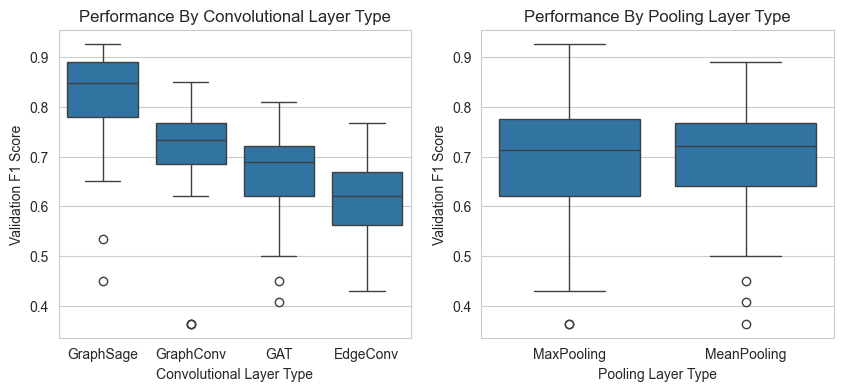

In [55]:
# Create figure with subplots
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

# Plot validation performance as function of number of convolutional layer type
plot_boxplot(training_results_df, y=("val_results", "f1"), x=("model_hyperparams", "conv"), ax=axs[0])
plot_boxplot(training_results_df, y=("val_results", "f1"), x=("model_hyperparams", "pooling"), ax=axs[1])

# Add plot labels and styles
axs[0].set(
    xlabel="Convolutional Layer Type",
    ylabel="Validation F1 Score",
    title="Performance By Convolutional Layer Type",
)
axs[0].set_xticks(range(4))
axs[0].set_xticklabels(["GraphSage", "GraphConv", "GAT", "EdgeConv"])

axs[1].set(
    xlabel="Pooling Layer Type",
    ylabel="Validation F1 Score",
    title="Performance By Pooling Layer Type",
)

# Save figure
fig.savefig(os.path.join(PLOT_PATH, "perf_vs_conv_pool.png"), bbox_inches="tight")

Nice! Let's try to look at a more dense representation using a scatter plot that relates the number of parameters to the validation performance. Additionally, we encode the convolutional layer type through hue and the global pooling type through different shapes 

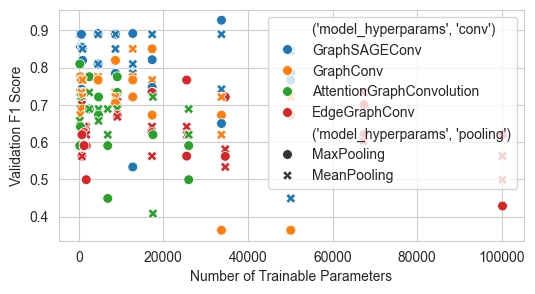

In [77]:
# Plot validation performance scatter
fig, ax = plt.subplots(figsize=(6, 3))

plot_scatter(training_results_df,
             x=("other", "num_params"), 
             y=("val_results", "f1"), 
             hue=("model_hyperparams", "conv"), 
             style=("model_hyperparams", "pooling"),
             ax=ax)

ax.set(
    xlabel="Number of Trainable Parameters",
    ylabel="Validation F1 Score",
);

# Save figure
fig.savefig(os.path.join(PLOT_PATH, "scatter_val_f1.png"), bbox_inches="tight", dpi=300)

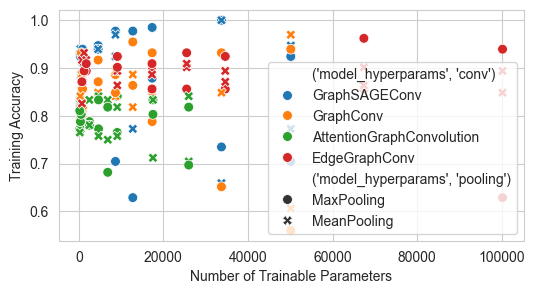

In [78]:
# Plot training performance scatter
fig, ax = plt.subplots(figsize=(6, 3))

plot_scatter(training_results_df,
             x=("other", "num_params"), 
             y=("train_results", "accuracy"), 
             hue=("model_hyperparams", "conv"), 
             style=("model_hyperparams", "pooling"),
             ax=ax)

ax.set(
    xlabel="Number of Trainable Parameters",
    ylabel="Training Accuracy",
);

# Save figure
fig.savefig(os.path.join(PLOT_PATH, "scatter_train_accuracy.png"), bbox_inches="tight", dpi=300)

Let's see how the model complexity (number of layers and hidden dimension in each layer) relates to the validation performance. To investigate, we plot a heatmap with the number of layers on the x-axis, the hidden dimension on the y-axis and the validation performance as the color.

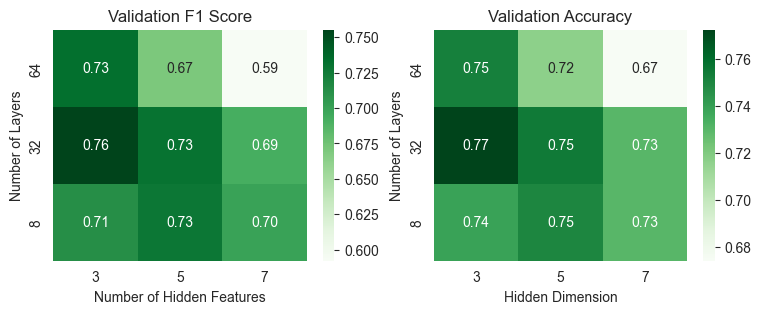

In [57]:
# Plot heatmap of validation performance for number of layers and hidden dimension
fig, axs = plt.subplots(ncols=2, figsize=(9, 3))
plot_heatmap(training_results_df, 
             y=("model_hyperparams", "num_layers"), x=("model_hyperparams", "conv_dim"), values=("val_results", "f1"), ax=axs[0])
plot_heatmap(training_results_df, 
             y=("model_hyperparams", "num_layers"), x=("model_hyperparams", "conv_dim"), values=("val_results", "accuracy"), ax=axs[1])

axs[0].set(
    title="Validation F1 Score",
    xlabel="Number of Hidden Features",
    ylabel="Number of Layers",
);
axs[1].set(
    title="Validation Accuracy",
    xlabel="Hidden Dimension",
    ylabel="Number of Layers",
);

fig.savefig(os.path.join(PLOT_PATH, "perf_vs_layers_dims.png"), bbox_inches="tight", dpi=300)

### Final Model

Finally, let's use the best performing model and evaluate it on the test set.

In [59]:
# Get best model based on validation F1
best_model_idx = training_results_df[("val_results", "f1")].argmax()
best_model_info = training_results_df.iloc[best_model_idx]

# Save train and model hyperparameters
train_params = best_model_info["train_hyperparams"]
model_params = best_model_info["model_hyperparams"]

# Print best model's hyperparameters
best_model_info[["train_hyperparams", "model_hyperparams", "val_results"]]

train_hyperparams  learning_rate              0.0
                   epochs                     100
model_hyperparams  num_features                 7
                   num_layers                   5
                   conv_dim                    64
                   conv             GraphSAGEConv
                   pooling             MaxPooling
val_results        loss                      0.56
                   accuracy                  0.93
                   f1                        0.93
Name: 6922651fc7154cb09491dedfa4781281, dtype: object

Let's retrain the model on the full training data and evaluate it on the test data.

In [60]:
# Combine train and validation data
train_val_data = train_data + val_data
train_val_loader = DataLoader(train_val_data, batch_size=1, shuffle=True)

# Initialise best model
best_model = GNN(**model_params)

optimser = torch.optim.Adam(best_model.parameters(), lr=train_params["learning_rate"])
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([train_ratio]))

train_results = train(best_model, train_val_loader, test_loader, criterion, optimser, epochs=train_params["epochs"], use_edges=False, verbose=1)

100/100 | Train 0.0391 (98.8%) | Val 0.5143 (89.3%): 100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


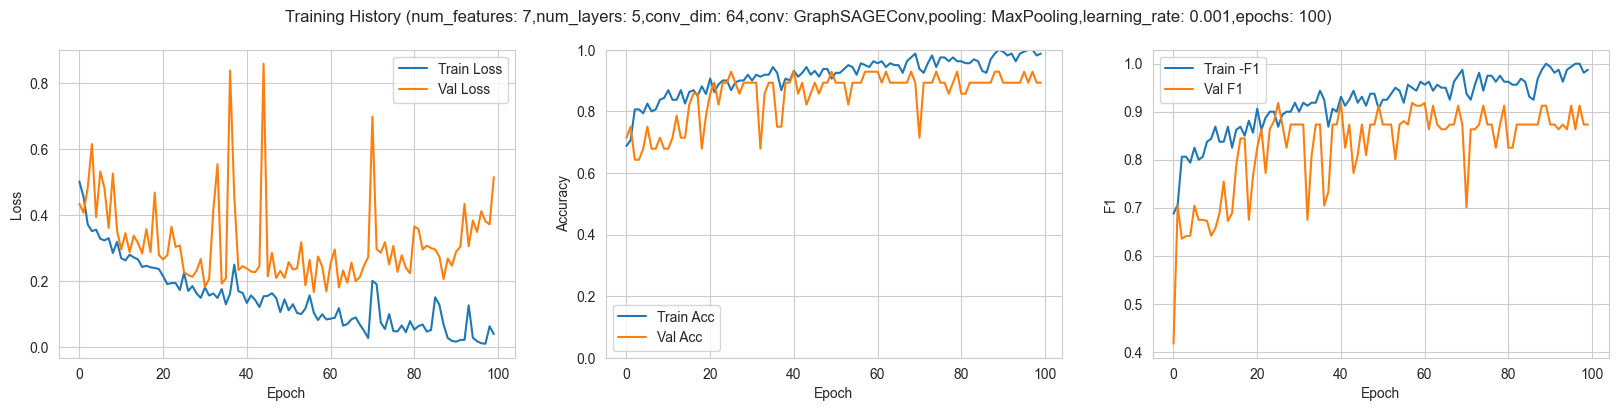

In [72]:
# Plot training curve of best model
fig = plot_training_history(train_results, kwargs={**model_params, **train_params})

# Save figure
fig.savefig(os.path.join(PLOT_PATH, "training_curve.png"), bbox_inches="tight", dpi=300)

In [61]:
# Test best model
test_results = validate(best_model, test_loader, criterion, verbose=True)

              precision    recall  f1-score   support

         0.0       0.78      0.88      0.82         8
         1.0       0.95      0.90      0.92        20

    accuracy                           0.89        28
   macro avg       0.86      0.89      0.87        28
weighted avg       0.90      0.89      0.89        28



In [62]:
# Print numeric test results
print("Test results")
pd.Series(test_results)

Test results


loss                             0.51
accuracy                         0.89
f1                               0.87
confusion_matrix    [[7, 1], [2, 18]]
dtype: object

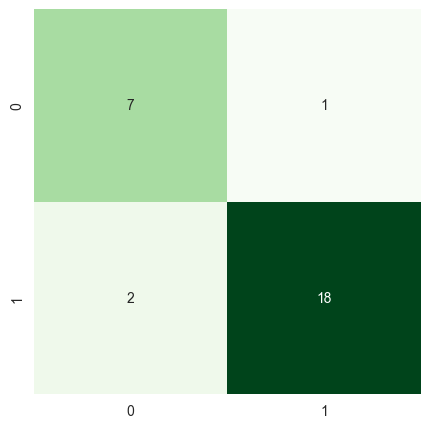

In [63]:
# Print out heatmap of confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(test_results["confusion_matrix"], annot=True, fmt="d", cmap="Greens", cbar=False, ax=ax);

fig.savefig(os.path.join(PLOT_PATH, "confusion_matrix.png"), dpi=300)